# Модель машинного обучения для прогноза оценки отеля, поставленной постояльцем 

Целью данной работы, как видно из названия, является создание модели машинного обучения, которая, основываясь на исходных данных, сможет спрогнозировать оценку отелю. 

Исходный датасет, на основе которого будет строиться модель представляет собой набор данных, из 17-ти признаков и 386803 экземпляров данных. 

В ходе работы данные исходного датасета будут проанализированы, обработаны, часть из них удалено, а часть новых признаков добавятся. 

На основе подготовленного датасета будет произведено обучение модели машинного обучения, и произведена оценка ее эффективности. 

В ходе работы используются такие библиотеки как: pandas, numpy, datetime, re, bs4, requests, matplotlib.pyplot, seaborn, timeit, nltk, а так же, различные модули этих библиотек. 

In [1]:
# Произведем импорт необходимых библиотек

# Стандартныен библиотеки для работы с DF
import pandas as pd
import numpy as np
import datetime

# Библиотека для поиска сочетаний (регуляров) 
import re

# Библиотеки для парсинга
from bs4 import BeautifulSoup
import requests

# Библиотека для кодирования 
import category_encoders as ce

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт модуля для предварительной обработки данных
from sklearn import preprocessing

# Используется для подсчета времени обучения в разделе 
# "Модель машинного обучения"
from timeit import default_timer as timer
from datetime import timedelta

# Библиотека и методы для определения эмоционального настроя текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('vader_lexicon')

# инструмент для создания и обучения модели  
from sklearn.ensemble import RandomForestRegressor 

# инструменты для оценки точности модели 
from sklearn import metrics 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nitys\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Произведем загрузку чтение исходного датасета, выведем на экран
# url='https://drive.google.com/file/d/1ExarL1MXX0ofyr5XmKwVGbtHHORIyNsS/view?usp=drive_link'
# url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# hotels = pd.read_csv(url)

hotels = pd.read_csv('data/hotels.csv')

hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


**Пояснение признаков DF:**

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве;

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

___
## Обработка DF на предмет дубликатов и пропусков

In [3]:
# Произведем поиск и удаление дубликатов (при наличии) 
hotels_dupl = hotels[hotels.duplicated()]

if hotels_dupl.shape[0] != 0:
    hotels = hotels.drop_duplicates()
    print('Имелись дубликаты в количестве {} шт. ' 
        'Данные очищены от дубликатов.'.format(hotels_dupl.shape[0]))

else:
    print('Дубликатов нет')
    
# Произведем проверку наличия пропусков 
null_cols = hotels.isnull().sum()
data_null_cols = null_cols[null_cols > 0]

print(('Пропусков нет', 'Имеются пропуски, нужна обработка')
      [data_null_cols.shape[0] != 0]
      )

Имелись дубликаты в количестве 307 шт. Данные очищены от дубликатов.
Имеются пропуски, нужна обработка


In [4]:
# Кол-во строк с пропусками, вычисление процента пропусков
missed_data_qnt = hotels[hotels.isna().any(axis=1)].shape[0]
print(f'Количество строк с пропусками данных = {missed_data_qnt} \n')

missed_data_perc = (missed_data_qnt / hotels.shape[0])*100
print(f'Процент данных с пропусками = {round(missed_data_perc,2)} \n')

hotels.info()

Количество строк с пропусками данных = 2448 

Процент данных с пропусками = 0.63 

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64

Из полученных данных мы видим, что пропуски имеются в части гео-данных отелей.
Проверим, возможно получится взять отсутствиующие координаты из данного датасета. Возможно, для части одних и тех же отелей они указаны, а для части нет. 

In [ ]:
# Создадим список адресов отелей, коориданты которых не указаны
geo_missed_hotel_address = list(hotels[hotels['lat'].isnull()]['hotel_address'].unique())

# Пройдем циклом по DF, в поисках значений координат. Проверим по адресам отелей, 
# возможно, в каких-то строках для этих отелей будут указаны координаты

for elem in geo_missed_hotel_address:
    
    # Создадим список булевых значений по пропускам и проверим условием имеются ли
    # в нем значения False (значит координаты по отелю в DF есть).
    values_list_bool = list[
        hotels[hotels['hotel_address'] == f'{elem}']['lat'].isnull()
        ]
    
    if False in values_list_bool:
        print(f'!!! We have match for the address {elem}')
    else:
        print(f'No matches for the address {elem}')
        
# Какое количество уникальных значений пропусков 
print(f'У {len(geo_missed_hotel_address)} отелей отсутствуют гео-данные' )

No matches for the address Savoyenstra e 2 16 Ottakring 1160 Vienna Austria
No matches for the address 23 Rue Damr mont 18th arr 75018 Paris France
No matches for the address Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria
No matches for the address W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria
No matches for the address 4 rue de la P pini re 8th arr 75008 Paris France
No matches for the address Sieveringer Stra e 4 19 D bling 1190 Vienna Austria
No matches for the address Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria
No matches for the address Bail n 4 6 Eixample 08010 Barcelona Spain
No matches for the address Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria
No matches for the address Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria
No matches for the address Paragonstra e 1 11 Simmering 1110 Vienna Austria
No matches for the address W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria
No matches for the address 20 Rue De La Ga t 14th arr 75014 

Мы видим, что по 17 отелям отсутствуют гео-данные. 

Ввиду того, что это небольшое количество, есть возможность заполнить пропуски реальными данными, а не прибегать к методу заполнения путем применения каких-то усреденных значений. 

Для поиска координат воспользуемся обычным сервисом google-карт, который позволяет по поиску в "два клика" получить и скопировать координаты адреса. 

Создадим отдельный DataFrame, с которого потом перенесем данные в исходный DataFrame. 

In [6]:
# DF с адресами отелей с пропущенными гео-данными, и гео-денные по адресам
missed_geo_hotels_df = pd.DataFrame({
    'h_address' : ['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria', 
                   '23 Rue Damr mont 18th arr 75018 Paris France', 
                   'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria', 
                   'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria', 
                   '4 rue de la P pini re 8th arr 75008 Paris France',
                   'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
                   'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
                   'Bail n 4 6 Eixample 08010 Barcelona Spain',
                   'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
                   'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
                   'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
                   'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
                   '20 Rue De La Ga t 14th arr 75014 Paris France',
                   'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
                   'Sep lveda 180 Eixample 08011 Barcelona Spain',
                   'Pau Clar s 122 Eixample 08009 Barcelona Spain',
                   'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria'],
    'lat' : [48.219583668024804, 48.888947389070026, 48.20962842193975, 48.22024772638908, 
        48.856838848218345, 48.24586742305909, 48.20906009960404, 41.39200796097634, 
        48.22500245912529, 48.20022540924419, 48.1638831889411, 48.224888096971725, 
        48.8400089935977, 48.24666762458812, 41.38484416401104, 41.392719066192114, 
        48.20965797171874
    ],
    'lng' : [16.2855813682633, 2.3331019682935326, 16.353311239427967, 16.355787539428473, 
             2.3047215971269517, 16.34263359781606, 16.41493483450979, 2.1756923179042045, 
             16.35692766320586, 16.391574519340875, 16.44542622468532,  16.357013493884892,  
             2.324275680907269, 16.34246193645799, 2.1609370894466107, 2.1671555526365904,
             16.351416597097717
    ]
    })

# Заполнение пропусков исходного DF данными с вновь созданного DF
hotels = hotels.set_index('hotel_address').fillna(
    missed_geo_hotels_df.set_index('h_address')).reset_index()

Этап очистки данных и заполнения пропусков окончен. Приступим к следующему этапу. 

___
## Анализ признаков и работа с ними (преобразование, удаление, проектирование новых признаков).

In [7]:
# Выведем на экран первые 2 строки для чтения и анализа
display(hotels.head(2))

# Возспользуемся встроенным методом описателельной стистики
display(hotels.describe(exclude=np.number))
display(hotels.describe(exclude='object'))


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386496,386496,386496,386496,386496,386496,386496,386496
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1910,3587,183952,95833,26863,3853,1910


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000
mean,498.504375,8.397421,18.539400,2744.679231,17.778163,7.176211,8.397299,49.433895,2.892805
std,500.365093,0.547861,29.703569,2316.934876,21.724766,11.052453,1.635747,3.462269,4.668041
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214066,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516288,4.841163
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.445426


По результатам методов описательной статистики можно наблюдать, что часть признаков требует преобразования. Рассмотрим более подбробно. 

### Признак hotel_address

Весь адрес отеля с точки зрения дальнейшей работы модели машинного обучения нам ничего не даст. 

Пойдем следующим путем: возьмем из адреса только страну отеля, и, на следующих этапах обработки, закодируем этот признак, для преобразования значений к числовым выражениям. 

In [8]:
# Пропишем функцию для извлечения страны из признака адреса отеля
def country_extract(string):
    country = list(string.split(' '))[-1]
    return country

# Создадим новый признак страны отеля, применив функцию к адресу
hotels['country'] = hotels['hotel_address'].apply(country_extract)

# По результату получили одно из значений 'Kingdom', 
# Напишем функцию, дающую полное название страны
hotels['country'] = hotels['country'].apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x
    )

# Удалим признак адреса, он для модели не пригоден 
hotels = hotels.drop('hotel_address', axis=1)

display(hotels['country'].value_counts())

country
United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: count, dtype: int64

Итого, мы получили признак с всего с 6-ю уникальными значениями. На этапе кодировани признак подвергнется однократному горячему кодированию. 

### Признак hotel_name

Аналогично предыдущему признаку, с точки зрения модели машинного обучения, он бесполезен. Однако, мы можем его преобразовать и извлечь из него полезную нам информацию. 

#### Формирование множества ключевых слов, указывающих на принадлежность отеля к группе с хорошим уровнем сервиса 

Мы можем обогатить наш исходный DF данными по принадлежности отеля к определенной группе. Для этого, будут задействованы данные по чартам отелей (топ-лист), а так же, принадлежность отеля к сетевым структурам, т.к. сетевые структуры, имея определенные стандарты серсвиса, притендуют на качество "по умолчанию". Эти данные могут оказывать влияние на оценку, поставленную отелю. 

##### Далее в работе будут использованы данные со внешних источников 
Список источников представлен в файле по ссылке: 

https://docs.google.com/document/d/1PUYIL8ydxhWoZgZ_NIHCjhfQRvwLsaC01Li4m3dZ3QY/edit?usp=drive_link

##### Общая стратегия следующая: 

Задействованы три источника данных: 

1. Скаченный датасет с kaggle.com, представляющий топ-50 отелей в мире. 
2. Парсинга сайта tripadviser.com, конкретно страницы с топ-25 отелей Европы. 
3. Копирование данных с сайта wikipedia.com и перенос их в формат CSV. 

Далее, по каждому блоку будет произведено преообразование в части вычленения названий отелей и их разбивка на отдельные слова и формирование списков слов по каждому блоку. После список преобразуется в множество для удаления повторяющихся значений.

Затем, множества по трем блокам объединяются в одно множество. 

Очистка множества от общеупотребимых в части отелей слов как the, inn, hotel, resort и прочее. 

##### Топ-50 отелей в мире

Датасет был перегружен из источника на гугл-диск. Представленные в коде ссылки видут на перезалитый файл. 

In [9]:
# Произведем чтение DF
url='https://drive.google.com/file/d/1ATDWtM5RP-OtiFLUuePr5VGzcP3Cpdtx/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
top_50_world_df = pd.read_csv(url, encoding='latin-1')

# Пустой список, куда занесем отдельные слова из названий отелей
top_50_world_list = []

# Функция для извлечения слов из названий отелей
def top_50_name_extract(name):
    words = str(name).split(' ')
    for word in words:
        top_50_world_list.append(word.lower())

# Применим функцию    
top_50_world_df['Name'].apply(top_50_name_extract)

# Преобразуем список в множество
top_50_world_set = set(top_50_world_list)

##### Топ-25 отелей Европы

Произведем парсинга сайта tripadviser.com, конкретно его страницы с чартом топ-25 отелей Европы. 

In [10]:
# Функция для парсинга сайта, маскируемся под браузер для обхода блокировки
def get_page_contents(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'}
    page = requests.get(url, headers=headers)
    return BeautifulSoup(page.text, 'html.parser')

# Адрес интересующей нас страницы
url = 'https://www.tripadvisor.com/TravelersChoice-Hotels-cTop-g4.html'

# Создание объект beatiful soup
soup = get_page_contents(url)

# Создание предобработанного списка, в элементах которого будут 
# содержатся названия отелей
top_25_dirty_list = str(soup).split('</h2')

# Счетчик итераций (в первом элементе в отличии от всех остальных элементов 
# отличается регулярное выражения для выборки названия отеля)
counter = 0

# Пустой список, будем наполнять названиями отелей
top_25_tripadv = []

# Циклом вычленяем названия отелей из предообработанного списка 
for elem in top_25_dirty_list:
    
    # Обработчик исключений, для успешного выполнения цикла
    try:
        if counter == 0:
            name = re.search('eIegw">(.*)', str(elem))
        else:
            name = re.search('rRtyp">(.*)', str(elem))
        name = name.group(1)
        top_25_tripadv.append(name)
    except:
        continue
    counter += 1
    
# Пустой список, куда занесем отдельные слова из названий отелей
top_25_europe_list = []

# Циклом вычленяем отдельные слова из названий отелей 
for name in top_25_tripadv:
    
    words = name.split(' ')
    for word in words:
        top_25_europe_list.append(word.lower())

# Преобразуем список в множество
top_25_europe_set = set(top_25_europe_list)

##### Список сетевых отелей

Скопируем данные с сайта википедии в csv файл и произведем обработку данных. 

In [11]:
# Ссылка на сформированный файл
url='https://drive.google.com/file/d/1yf85a0arfHVMmU3jqOpua7Ov0FtYjpTa/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

# Создание DF из файла
chain_hotels = pd.read_csv(url, sep=';')

# Список названий отелей из DF
chain_hotels_list_orig = list(chain_hotels['Managed brands'])

# Пустой список, куда занесем отдельные слова из названий отелей
chain_hotels_list = []

# Вычленим циклом слова из названий отелей и занесем их с список выше
for name in chain_hotels_list_orig:
    # Обработчик исключений требуется для избежания вызова ошибок при обработки 
    # (имеются числовые данные и символы в результате преобразования)
    try:
        words = list(name.split(' '))
        for word in words: 
            chain_hotels_list.append(word.lower())
    except:
        continue

# Преобразуем список в множество
chain_hotels_set = set(chain_hotels_list)

In [12]:
# Объединим множества 

key_words_top = top_50_world_set.union(top_25_europe_set)
key_words_top = key_words_top.union(chain_hotels_set)

In [13]:
# Создадим список слов к удалению из множества
# Данные слова/артикли могут быть общими как для брендового отеля, 
# так и для обычного, так же, внесем названия столиц, представленных стран
excluding_words = {'hotel', 'spa', 'resort', 'inn', 'ink', 'apartment', 
                   'apart', 'villa', 'hostel', 'motel', 'bed', 'breakfast', 
                   'b&b', 'palace', 'park',
                   
                   'the', 'by', 'a', 'an', 'of', 'in', 'la', 'les', 'le',
                   
                   'london', 'paris', 'amsterdam', 'madrid', 'barcelona', 
                   'vienna', 'rome'
                   }

key_words = key_words_top.difference(excluding_words)
len(key_words)

502

In [14]:
# Функция проверки вхождения множества слов из названия отеля в 
# ранее созданное множество слов характерных для сетевых или топовых отелей
# Функция возвращает 1 - если есть вхождение, в противном случае - 0.
def hotel_name_top(name):
    words = name.split(' ')
    name_set = set()
    
    for word in words:
        name_set.add(word.lower())
    
    if name_set.intersection(key_words):
        return 1
    else:
        return 0


# Создание нового бинарного признака является ли отель сетевым/топовым
hotels['top'] = hotels['hotel_name'].apply(hotel_name_top)

# Выведем на экран резултаты по среднему рейтингу постояльцев 
# по каждой группе и в общем
print(
    'Средний рейтинг постояльцев по группе отелей, входящий в ТОП: ',
    round(hotels[hotels['top'] == 1]['reviewer_score'].mean(), 3)
    )
print(
    'Средний рейтинг постояльцев по группе отелей, НЕ входящий в ТОП: ',
    round(hotels[hotels['top'] == 0]['reviewer_score'].mean(), 3)
    )
print(
    'Средний рейтинг постояльцев по всем отелям: ',
    round(hotels['reviewer_score'].mean(), 3)
    )

# Удалим признак названия отеля
hotels = hotels.drop(['hotel_name'], axis =1)

hotels_test = hotels.copy()
hotels.head(1)

Средний рейтинг постояльцев по группе отелей, входящий в ТОП:  8.356
Средний рейтинг постояльцев по группе отелей, НЕ входящий в ТОП:  8.451
Средний рейтинг постояльцев по всем отелям:  8.397


,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country,top
0,581,2/19/2016,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,0


На данном этапе получили неожиданный результат, что средняя оценка гостей по отелям, входящим в сетевые структуры, либо принадлежащих к рейтингу лучших отелей ниже, чем по группе отелей, не принадлежащих к сетевым. 

Обработку признака hotel_name завершили. 

### Признак review_date

Просто список дат для модели не подойдет. Поэтому преобразование данного признака сведем к определению сезона года. Есть вероятность, что сезон года может сказываться на рейтинг отеля. 

In [15]:
# Преобразуем тип признака в datetime, воспользуемся аксессором по месяцу
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'] = hotels['review_date'].dt.month
hotels['review_date'] = hotels['review_date'].astype('int64')

# Функция преобразования месяца в сезон
def season_detect(month):
    if month in [12, 1, 2]:
        return 'winter'
    if month in [3, 4, 5]:
        return 'spring'
    if month in [6, 7, 8]:
        return 'summer'
    if month in [9, 10, 11]:
        return 'autumn'

# Создание нового признака сезона отзыва постояльца
hotels['review_season'] = hotels['review_date'].apply(season_detect)

# Удалим уже ненужный признак
hotels = hotels.drop(['review_date'], axis=1)

В дальнейшем признак будет закодирован однократным горячим кодированием. Преобразование признака закончено. 

### Признак days_since_review

Количество уникальных значений велико. Укрупним показатели, сгруппируем по 100 дней. Последняя группа будет несколько больше, чем 100.

In [16]:
# Функция преобразования признака в категориальный
def days_convert(feature):
    days = int(feature.split(' ')[0])
    if 0 <= days < 100:
        return '0-100' 
    if 100 <= days < 200:
        return '100-200' 
    if 200 <= days < 300:
        return '100-300' 
    if 300 <= days < 400:
        return '300-400' 
    if 400 <= days < 500:
        return '400-500' 
    if 500 <= days < 600:
        return '500-600' 
    if 600 <= days:
        return '<_600' 

# Создание нового категориального признака времени, прошедшего с обзора
hotels['days_since_review'] = hotels['days_since_review'].apply(
    days_convert
    )

Мы преобразовали признак в категориальный с 7-ю уникальными значениями. Признак не удаляли, просто обновили его. 

### Признак reviewer_nationality

Признак имеет 225 уникальных значений. И, имеет текстовый формат. Произведем создание нового признака, характеризущее, является ли гражданство постояльца тем же, что и страна нахождения отеля. Возможно, это оказывает какое-то влияние на оценки. 

In [17]:
# Обработаем исходный признак, удалив лишние пробелы в строковых данных
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x.strip()
    )

# Функция для сравнения значений двух признаков
# Возвращает 1, если совпадение, в противном случае 0
def compare_country(col_1, col_2):
    if str(col_1) == str(col_2):
        return 1
    else:
        return 0

# Создаем новый признак, свидетельствующий о равности гражданства и страны отеля
hotels['same_country'] = hotels.apply(
    lambda x: compare_country(x.reviewer_nationality, x.country), axis = 1
    ) 

# Удаляем признак гражданства постояльца
hotels = hotels.drop(['reviewer_nationality'], axis = 1)

### Признаки positive_review, negative_review

Из текстового описания мы сможем извлечь информацию о "настроении" отзыва. Сделаем это при помощи библиотеки NLTK - [Natural Language Kit](https://www.nltk.org/).

Конкретно, воспользуемся методом SentimentIntensityAnalyzer() и библиотекой слов VADER. 

На "выходе" метод выдает 4 значения: compound - общее "настроение" текста - считается по сумме коэффициентов эмоциональности каждого слова; pos, neu, neg - коэфициенты позитивного, нейтрального и негативного окраса текста (здесь уже анализируется строка в целом). 

Поэтому поступим с формированиями новых признаков следующим образом. 

Признак **vader_score_pos** - для его формирования на вход метода будет подан позитивный отзыв, а на выходе возьмем коэфциент pos 

Признак **vader_score_neg** - для его формирования на вход метода будет подан негативный отзыв, а на выходе возьмем коэфциент neg 

Признак **vader_score** - для его формирования на вход метода будет подана "склейка" из позитивного и негативного отзывов, а на выходе возьмем коэфциент compound. Обоснованием данного подхода является то, что compound подсчитывает сумму из коэфициентов, поэтому на него мы имеем право подать все мнение постояльца целиком. 

Так же, в отзывах имеются такие значения, которые могут внести путаницу в работу алгоритма. Такие как, например, негативный отзыв "no negative", при подсчете суммарного значения эмоционального фона, даст нам отрицательные значения (т.е. как негатив), т.к. подсчитается сумма из no и negative, "цена" negative отрицательно высокая. И это не будет иметь смысла. Поэтому, предварительно очистим как негативные, так и позитивные отзывы на подобные вхождения. 


***Полученные коэффициенты будут выведены в отдельный файл***

***Общее время работы метода составили чуть более 2-ух часов. Для избежания повторных запусков, полученные значения будут выведены в отдельный DF, на его основе будет создан CSV файл, который будет загружен на гугл-диск.***

***Далее будет ссылка не его чтение и произведено конкатирование с hotel дата-фреймом.***

***Все ячейки, связанные с работой метода закомментированы целиком.***

In [18]:
"""

# Создадим новые признаки - копии существующих и с ними будем работать
hotels[['positive_rev_to_vader', 'negative_rev_to_vader']] = \
    hotels[['positive_review', 'negative_review']].copy()

# Функция для подмены позитивных слов в негативных отзывах
def negative_turnover(elem):
    neg_to_pos_list = ['leaving', 'no negative', 'nothing']
    for word in neg_to_pos_list:
        elem = elem.lower()
        elem = elem.replace(f'{word}', 'positive')
    return elem

# Функция для подмены негативных слов в позитивных отзывах
def positive_turnover(elem):
    pos_to_neg_list = ['nothing', 'no positive']
    for word in pos_to_neg_list:
        elem = elem.lower().replace(f'{word}', 'negative')
    return elem
    
# Применений функций к признакам
hotels['negative_rev_to_vader'] = \
    hotels['negative_rev_to_vader'].apply(negative_turnover)


hotels['positive_rev_to_vader'] = \
    hotels['positive_rev_to_vader'].apply(positive_turnover)

# "Склейка" позитивного и негативного отзывов в единый (для извлечений compound)
hotels['to_vader'] = \
    hotels['positive_rev_to_vader'] + hotels['negative_rev_to_vader'] 

# Функция для получения коэффициента общего значения 
# по словам суммарного отзыва
def vader_analics(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['compound']

# Создание нового признака 
hotels['vader_score'] = hotels['to_vader'].apply(vader_analics)

"""

'\n\n# Создадим новые признаки - копии существующих и с ними будем работать\nhotels[[\'positive_rev_to_vader\', \'negative_rev_to_vader\']] =     hotels[[\'positive_review\', \'negative_review\']].copy()\n\n# Функция для подмены позитивных слов в негативных отзывах\ndef negative_turnover(elem):\n    neg_to_pos_list = [\'leaving\', \'no negative\', \'nothing\']\n    for word in neg_to_pos_list:\n        elem = elem.lower()\n        elem = elem.replace(f\'{word}\', \'positive\')\n    return elem\n\n# Функция для подмены негативных слов в позитивных отзывах\ndef positive_turnover(elem):\n    pos_to_neg_list = [\'nothing\', \'no positive\']\n    for word in pos_to_neg_list:\n        elem = elem.lower().replace(f\'{word}\', \'negative\')\n    return elem\n    \n# Применений функций к признакам\nhotels[\'negative_rev_to_vader\'] =     hotels[\'negative_rev_to_vader\'].apply(negative_turnover)\n\n\nhotels[\'positive_rev_to_vader\'] =     hotels[\'positive_rev_to_vader\'].apply(positive_turnov

In [19]:
"""

# Функция для получения коэффициента позитивного окраса 
# по словам позитивного отзыва
def vader_analitics_positive(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['pos']

# Создание нового признака 
hotels['vader_score_pos'] = hotels['positive_rev_to_vader'].apply(vader_analitics_positive)

"""

"\n\n# Функция для получения коэффициента позитивного окраса \n# по словам позитивного отзыва\ndef vader_analitics_positive(review):\n    sid = SentimentIntensityAnalyzer()\n    ss = sid.polarity_scores(review)\n    return ss['pos']\n\n# Создание нового признака \nhotels['vader_score_pos'] = hotels['positive_rev_to_vader'].apply(vader_analitics_positive)\n\n"

In [20]:
"""

# Функция для получения коэффициента негативного окраса 
# по словам негативного отзыва
def vader_analitics_negative(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['neg']

# Создание нового признака 
hotels['vader_score_neg'] = hotels['negative_rev_to_vader'].apply(vader_analitics_negative)

"""

"\n\n# Функция для получения коэффициента негативного окраса \n# по словам негативного отзыва\ndef vader_analitics_negative(review):\n    sid = SentimentIntensityAnalyzer()\n    ss = sid.polarity_scores(review)\n    return ss['neg']\n\n# Создание нового признака \nhotels['vader_score_neg'] = hotels['negative_rev_to_vader'].apply(vader_analitics_negative)\n\n"

In [21]:
"""

# Список признаков к копированию 
# (коэффциентов от работы метода SentimentIntensityAnalyzer)
verdered_feats_list = ['vader_score', 'vader_score_pos', 'vader_score_neg']

# Выведем полученные значения 

vader_scores = hotels[verdered_feats_list].copy()
vader_scores.to_csv('data/vader_scores.csv', index=False)

"""

"\n\n# Список признаков к копированию \n# (коэффциентов от работы метода SentimentIntensityAnalyzer)\nverdered_feats_list = ['vader_score', 'vader_score_pos', 'vader_score_neg']\n\n# Выведем полученные значения \n\nvader_scores = hotels[verdered_feats_list].copy()\nvader_scores.to_csv('data/vader_scores.csv', index=False)\n\n"

In [22]:
url = 'https://drive.google.com/file/d/1elFVTH5-fQj_0y7fqt5X09Kwh_DNhIGB/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

vader = pd.read_csv(url)

hotels = pd.concat([hotels, vader], axis=1)

### Признаки review_total_negative_word_counts и review_total_positive_word_counts

Сами по себе признаки, вероятно, несут влияние на прогноз оценки. Но, стоит обратить внимание на расхождение реального количества слов в отзывах с самими отзывами. 

Произведем повторную генерацию этих признаков, и назовем их negative_word_qnt, positive_words_qnt,

А уже на основе этих признаков создадим новый признак pos_neg_ratio - отношение количества слов позитивного отзыва к количеству слов негативного отзыва. 

*В случае отсутствия негативных слов, к каждому из признаков будет добавлено число 1 для произведения вычислений и обхода ошибки деления на 0.*

Так же, в первом образце, касаемо негативного отзыва, бросается в глаза комментарий "Leaving", что скорее свидетельствует о крайне позитивном отношении постояльца к отелю и о его грусти в связи с отъздом. На это тоже сделаем проверку и заменим значения количества слов на 0. Аналогично поступим с комментарием "no negative" и "no positive" - для позитивного отзыва. Схожую процедуру мы проделывали ранее, когда готовили данные для выполненения метода по определению эмоционального окраса текста. 

Завершающим этапом удалим ненужные признаки, оставив только корректные числовые (negative_word_qnt, positive_words_qnt, pos_neg_ratio).

In [23]:
# Создадим копии признаков, которые будем обрабатывать
hotels['negative_review_copy'] = hotels['negative_review']
hotels['positive_review_copy'] = hotels['positive_review']

# Произведем удаление значений, не характеризующих негативный 
# или позитивный опыт
hotels['negative_review_copy'] = \
    hotels['negative_review_copy'].apply(
    lambda x: '' if (x.strip().lower() == 'leaving') |
    (x.strip().lower() == 'no negative')
    else x
    )

hotels['positive_review_copy'] = \
    hotels['positive_review_copy'].apply(
    lambda x: '' if (x.strip().lower() == 'no positive') else x
    )
    
# Список частиц, не участвующих в подсчете слов, так же, 
# сюда добавим пустое значение, оно местами присутствует в DF, 
# и, вероятно, в оригинальном датасете и давало лишние числа
article_list = ['the', 'a', 'an', 'and', 'of', 'in', 'on', 'or', '']

# Функция подсчета слов
def word_counter(rev):
    
    result = []
    
    rev = rev.strip().lower()
    rev_list = rev.split(' ')
    
    for elem in rev_list:
        if elem not in article_list:
            result.append(elem)
    
    return len(result)

# Создадим новые признаки количества слов, применив функцию
hotels['negative_word_true'] = \
    hotels['negative_review_copy'].apply(word_counter)

hotels['positive_word_true'] = \
    hotels['positive_review_copy'].apply(word_counter)

# Функция расчета соотношения позитивных слов к негативным
def ratio_calc(negative, positive):
    try:
        result = positive / negative
    except:
        result = (positive + 1) / (negative + 1)
        
    return result

# Создаем новый признак соотношения слов, применив функцию
hotels['pos_neg_ratio'] = hotels.apply(
    lambda x: ratio_calc(x.negative_word_true,
                         x.positive_word_true),
    axis = 1
    )

# Список признаков на удаление
list_to_drop_revs = ['negative_review_copy', 'positive_review_copy', 
                'negative_review', 'positive_review', 
                'review_total_negative_word_counts', 
                'review_total_positive_word_counts'
                ]

# Удаление признаков
hotels = hotels.drop(
    columns = list_to_drop_revs, axis=1
    )

# Переименуем колонки новых признаков
hotels = hotels.rename(columns={
    'negative_word_true' : 'negative_word_qnt',
    'positive_word_true' : 'positive_word_qnt'
    })

hotels.head(4)

,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country,top,review_season,same_country,vader_score,vader_score_pos,vader_score_neg,negative_word_qnt,positive_word_qnt,pos_neg_ratio
0,581,8.4,1994,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",500-600,51.507894,-0.143671,United Kingdom,0,winter,1,0.8126,0.655,0.000,0,3,4.0
1,299,8.3,1361,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",100-300,51.521009,-0.123097,United Kingdom,1,winter,1,-0.4767,0.000,0.756,2,1,0.5
2,32,8.9,406,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",100-300,48.845377,2.325643,France,1,autumn,0,-0.7096,0.000,0.423,3,0,0.0
3,34,7.5,607,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",<_600,48.888697,2.394540,France,1,autumn,0,0.9477,0.721,0.000,0,9,10.0


Ради предварительной оценки полученных признаков, визуализируем их взаимосвязь со средним значением оценки постояльцев в каждой категории признаков.

Text(0.5, 0.98, 'Связь признаков со средней оценкой отеля')

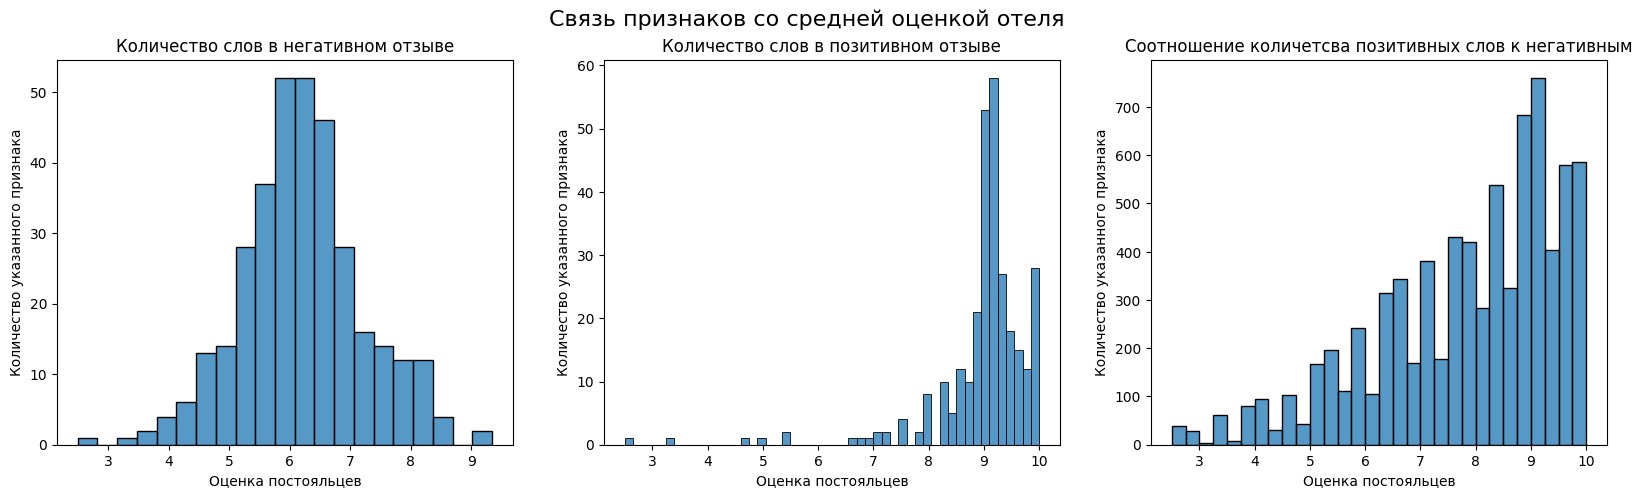

In [24]:
# Зададим subplot
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,5))

# Построим ряд гистограмм созданных признаков 
negative = sns.histplot(
    hotels.groupby(['negative_word_qnt'])['reviewer_score'].mean(),
    ax=axes[0], 
    )
negative.set_title('Количество слов в негативном отзыве')
negative.set_xlabel('Оценка постояльцев')
negative.set_ylabel('Количество указанного признака')


positive = sns.histplot(
    hotels.groupby(['positive_word_qnt'])['reviewer_score'].mean(),
    ax=axes[1], 
    )

positive.set_title('Количество слов в позитивном отзыве')
positive.set_xlabel('Оценка постояльцев')
positive.set_ylabel('Количество указанного признака')


ratio = sns.histplot(
    hotels.groupby(['pos_neg_ratio'])['reviewer_score'].mean(),
    ax=axes[2], 
    )

ratio.set_title('Соотношение количетсва позитивных слов к негативным')
ratio.set_xlabel('Оценка постояльцев')
ratio.set_ylabel('Количество указанного признака')

# Зададим заголовок subplot
fig.suptitle('Связь признаков со средней оценкой отеля', fontsize = 16)

На первый взгляд введеный признак соотношения положительных слов к негативным полезен. Видна зависимость увеличения оценки с увеличением коэффициента. 

Интересное наблюдение из других признаков, количество слов в положительных отзывах соотносится со средней оценкой, много слов = высокая оценка. 

Касательно же негативных слов ситуация совершенно иная. Наибольшее количество слов в отзывах соответствует среденей оценке. Тогда как их малое количество характерно как для высокой, так и для низкой оценки. Наблюдение интересно само по себе, складывается ощущение, что при очень негативном опыте, постояльцы настолько апатичны к отелю, что не расписывают конкретно причин своей низкой оценки. Но, что касается нашей задачи, модели машинного обучения, могут возникнуть сложности, т.к. одинаковое значение может указывать на диаметрально противоположные результаты. Возможно, от признака в дальнейшем придется избавиться. 

### Признак tags

Это информативный признак. Однако, в нем содержится много разрозненной информации. Так же, значения загрязнены форматом отображения. На основе этого признака мы создадим новые признаки. Но, для начала, надо его обновить и привести к нормальному виду. 

In [25]:
# Функция для очистки значений признака тагов от лишних элементов 
def tag_renewal(tag):

    tag = tag.split(',')

    # Формирование списка из очищенных тагов
    new_tag = list(map(
        lambda x: ( re.search( "' (.*) '", str(x) ) ).group(1).lower(), 
        tag
        ))
   
    # Возврат обновленного очищенного списка
    return new_tag

# Создаем новый признак, очищенную копию прошлого признака 
hotels['new_tags'] = hotels['tags'].apply(tag_renewal)

# Удалим отработанный признак
hotels = hotels.drop(columns=['tags'], axis=1)

#### Добавление новых признаков

На основе уже существующего и очищенного признака тэгов возможно создание новых признаков. Проведем изучение этого признака более подробно. Для этого выведем на экран первые 5 значений признака. 

In [26]:
for i in range(5):
    display(hotels.iloc[i]['new_tags'])

['leisure trip',
 'couple',
 'studio suite',
 'stayed 2 nights',
 'submitted from a mobile device']

['business trip', 'couple', 'standard double room', 'stayed 1 night']

['leisure trip',
 'solo traveler',
 'modern double room echo',
 'stayed 3 nights',
 'submitted from a mobile device']

['leisure trip',
 'solo traveler',
 'standard room with 1 double bed',
 'stayed 1 night']

['business trip', 'couple', 'standard double or twin room', 'stayed 6 nights']

Что мы видим, на первый взгляд, информация в значениях признака **структурирована**. Первое значение - тип путешествия, второе - состав путешественников, третее - тип размещения, четвертое - количество ночей, пятое, опционально, оставлен ли отзыв с мобильного телефона.

&nbsp;<br>
**Создадим ряд новых признаков изначально с бинарными значениями:**


**mobile_submit -** характеризует, оставлен ли отзыв с мобильного устроства, где 1 - с мобильного, 0 = не с мобильного

**leisure_trip -** характеризует, связано ли размещение с поездкой в отпуск, где 1 - да, свзано, 0 - не связано

**business_trip -** характеризует, связано ли размещение с командировкой, где 1 - да, свзано, 0 - не связано

&nbsp;<br>
**Создадим ряд новых признаков с категориальными значениями, которые в дальнейшем будут обработаны:**

**travelers -** занесем сюда значения, характеризующие состав постояльцев

**room_type -** занесем сюда типы размещений


&nbsp;<br>
**mobile_submit, leisure_trip, business_trip**

In [27]:
# Ряд типовых функция для обработки признака с возвратом бинарного значения
def is_mobile(feature):
    if re.findall('mobile device', str(feature)):
        return 1
    else:
        return 0

def is_leisure(feature):
    if re.findall('leisure trip', str(feature)):
        return 1
    else:
        return 0

def is_business(feature):
    if re.findall('business trip', str(feature)):
        return 1
    else:
        return 0

# Создание новых признаков с применением написанных функций
hotels['mobile_submit'] = hotels['new_tags'].apply(is_mobile)
hotels['leisure trip'] = hotels['new_tags'].apply(is_leisure)
hotels['business trip'] = hotels['new_tags'].apply(is_business)

**Обработка категориальных признаков**

In [28]:
# Обработка в части категориальных признаков будет связана с индексами 
# элементов списка - значения признака new_tags, поэтому, 
# необходимо сделать проверку на количество элементов списка, для 
# этого создадим вспомогательный признак - количество тагов .
hotels['tags_qnt'] = hotels['new_tags'].apply(
    lambda x: len(x)
    )

display(hotels['tags_qnt'].value_counts())

tags_qnt
5    223293
4    158448
3      4122
6       563
2        65
1         5
Name: count, dtype: int64

Видно, что большинство значений признаков соответствует структуре в 4-5 тагов. Однако, имеется 4755 признаков не соответствующих этому правило. К ним мы не сможем применить заполнение нового признака через индекс. 

Пойдем следующим путем, промежуточно создавая временные признаки, изучим какие ключевые слова встречаются для определея того или иного признака, а затем, по признаку тэгов проведем поиск нужных нам значений. И, классифицируя их, занесем как значения новых признаков. 

**Категория номера (room_type)**

In [29]:
# Функция для извлечения описание типа номера 
# (Применяем к тем строкам, где высока вероятность соблюдения порядка
# в тэгах, задаемся количеством тэгов больше или равно 4)
def room_extract(qnt, tag):
    if qnt >= 4:
        return tag[2]
    else: 
        return 'Unknown'

# Применим функцию к DF для создания временного признака с типом номера
hotels['room_type_temp'] = hotels.apply(
    lambda x: room_extract(x.tags_qnt, x.new_tags), axis = 1
    ) 

# Выведем на экран первые 30 значений признака, для определения 
# ключевых слов
hotels['room_type_temp'].value_counts().head(30)

room_type_temp
double room                     25497
standard double room            23389
superior double room            22843
deluxe double room              17985
double or twin room             16325
standard double or twin room    12669
classic double room             12288
superior double or twin room     9990
2 rooms                          9025
standard twin room               7040
single room                      6896
twin room                        6004
executive double room            4610
classic double or twin room      4471
deluxe double or twin room       4360
club double room                 4354
superior twin room               4344
Unknown                          4192
queen room                       3970
deluxe king room                 3869
superior queen room              3588
standard single room             3325
junior suite                     3290
triple room                      3273
stayed 1 night                   3199
classic room                     31

In [30]:
# На основе выбранных ключевых слов - функция для 
# определения категории номера 
def room_type(tags):
    tags = str(tags).lower()
    
    if re.findall('superior', tags) or \
        re.findall('deluxe', tags) or \
            re.findall('queen room', tags) or \
                re.findall('club', tags):
                    return 'superior'
    if re.findall('suite', tags):
        return 'suite'
    else:
        return 'standart'

# Создаем новый признак типа номера (он уже будет постоянный)
hotels['room_type'] = hotels['new_tags'].apply(room_type)

# Удалим временный признак типа номера 
hotels = hotels.drop(columns = ['room_type_temp'], axis=1)

**Состав путешественников (traveler_type)**

In [31]:
# Аналогичный подход к обработке признака состава путешественников

# Функция для извлечения описание состава путешественников 
# (Применяем к тем строкам, где высока вероятность соблюдения порядка
# в тэгах, задаемся количеством тэгов больше или равно 4)
def travelers_extract(qnt, tag):
    if qnt >= 4:
        return tag[1]
    else: 
        return 'Unknown'

# Применим функцию к DF для создания временного признака с типом номера
hotels['travelers_temp'] = hotels.apply(
    lambda x: travelers_extract(x.tags_qnt, x.new_tags), axis = 1
    ) 

# Выведем на экран первые 10 значений признака, для определения 
# ключевых слов
hotels['travelers_temp'].value_counts().head(10)

travelers_temp
couple                        184136
solo traveler                  77787
group                          47751
family with young children     43981
family with older children     19025
Unknown                         4192
travelers with friends          1583
leisure trip                     824
double room                      497
standard double room             438
Name: count, dtype: int64

Так же, стоит отметить, что в выборку попали значения признаков отличные от искомых (как то, категория номера). Поиск же ключевых слов, в отличии от просто занесения данных по индексу, позволит нам избежать внесения некорректных данных. 

In [32]:
# На основе выбранных ключевых слов - функция для 
# определения категории номера 
def travelers_type(tags):
    tags = str(tags).lower()
    
    if re.findall('solo', tags):
        return 'solo'
    if re.findall('group', tags) or \
        re.findall('friend', tags):
        return 'friends'
    if re.findall('family', tags) or \
        re.findall('child', tags):
        return 'family'
    if re.findall('couple', tags):
        return 'couple'
    else:
        return None

# Создаем новый признак типа номера (он уже будет постоянный)
hotels['traveler_type'] = hotels['new_tags'].apply(travelers_type)

# Удалим временный признак типа номера 
hotels = hotels.drop(columns = ['travelers_temp'], axis=1)

**Количество проведенных в отеле ночей (nights_qnt)**

In [33]:
# Функция для поиска значений количества ночей
def nights_calc(tags):
    try:
        tags = str(tags).lower()
        result = re.search('stayed (.*) night', tags).group(1)
        return int(result)
    except:
        return None

hotels['nights_qnt'] = hotels['new_tags'].apply(nights_calc)        

In [34]:
# Проверка пропусков нового признака
hotels['nights_qnt'].isnull().value_counts()

nights_qnt
False    386350
True        146
Name: count, dtype: int64

In [35]:
# Количество пропусков не вилико, заполним их медианой по признаку
hotels['nights_qnt'] = hotels['nights_qnt'].fillna(
    hotels['nights_qnt'].median()
    )

In [36]:
# Выведем информацию по новому признаку
hotels['nights_qnt'].value_counts()

nights_qnt
1.0     145296
2.0     100322
3.0      71940
4.0      35708
5.0      15592
6.0       7388
7.0       5541
8.0       1907
9.0        966
10.0       662
11.0       305
12.0       217
14.0       184
13.0       174
15.0        87
16.0        38
17.0        27
18.0        24
19.0        23
21.0        19
20.0        17
30.0        10
27.0        10
22.0         8
28.0         7
23.0         6
26.0         6
24.0         5
25.0         4
29.0         3
Name: count, dtype: int64

Избавимся от такого большого количества значений признака. Ограничемся 10 ночами, подразумевая под значением 10 - это 10 и более.

In [37]:
hotels['nights_qnt'] = hotels['nights_qnt'].apply(
    lambda x: 10 if x >= 10 else x
    ) 

Необходимую информацию из признака tags мы получили и создали на ее основе ряд новых признаков. 

Пришло время удалить данный признак из DF и признак количества тэгов. 

In [38]:
hotels = hotels.drop(columns = ['new_tags', 'tags_qnt'], axis=1)

In [39]:
# Произведем проверку по DF перед следующим этапом и обратим внимание 
# на типы данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   total_number_of_reviews                     386496 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 4   reviewer_score                              386496 non-null  float64
 5   days_since_review                           386496 non-null  object 
 6   lat                                         386496 non-null  float64
 7   lng                                         386496 non-null  float64
 8   country                                     386496 non-null  object 
 9   top                                         386496 non-null  int64  
 

### Этап проектирования признаков завершен

На данный момент был создан ряд новых признаков, пригодных к дальнейшей обработки. Оставшиеся признаки с типом данных object будут закодированы и удалены. 

___
## Кодирование признаков

Кодированию подлежат признаки с типом данных object. 

К ним относятся признаки days_since_review, country, review_season, room_type, traveler_type.

Количество значений по признакам меньше 15, все признаки, кроме "room_type" будут закодированы методом горячего однократного кодирования, признак "room_type" будет закодирован методом порядкового кодирования. 

In [40]:
hotels_encode = hotels.copy()

In [41]:
# Список признаков для кодирования
columns_to_encode = ['days_since_review', 
                     'country',
                     'review_season', 
                     'traveler_type'
                     ]

# Циклом произведем кодирование признаков
for feature in columns_to_encode:
    encoder = ce.OneHotEncoder(cols=[f'{feature}'], use_cat_names=True)
    type_bin = encoder.fit_transform(hotels_encode[f'{feature}'])
    hotels_encode = pd.concat([hotels_encode, type_bin], axis=1)

room_type_dict = {
    'standart' : 1,
    'superior' : 2,
    'suite' : 3
    }

# Порядковое кодирование признака room_type
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'room_type',
    'mapping': room_type_dict
    }])

data_bin = ord_encoder.fit_transform(hotels_encode['room_type'])

hotels_encode = pd.concat(
    # Сразу "по месту" произведем удаление исходного признака room_type
    [hotels_encode.drop(columns=['room_type'], axis=1), data_bin], 
    axis=1
    )

In [42]:
# Проверим корректность кодирования 
pd.set_option('display.max_columns', None)
display(hotels_encode.head(5))
pd.reset_option('display.max_columns', None)


,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,country,top,review_season,same_country,vader_score,vader_score_pos,vader_score_neg,negative_word_qnt,positive_word_qnt,pos_neg_ratio,mobile_submit,leisure trip,business trip,traveler_type,nights_qnt,days_since_review_500-600,days_since_review_100-300,days_since_review_<_600,days_since_review_0-100,days_since_review_100-200,days_since_review_400-500,days_since_review_300-400,country_United Kingdom,country_France,country_Netherlands,country_Italy,country_Austria,country_Spain,review_season_winter,review_season_autumn,review_season_spring,review_season_summer,traveler_type_couple,traveler_type_solo,traveler_type_family,traveler_type_friends,room_type
0,581,8.4,1994,7,10.0,500-600,51.507894,-0.143671,United Kingdom,0,winter,1,0.8126,0.655,0.000,0,3,4.0,1,1,0,couple,2.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,3
1,299,8.3,1361,14,6.3,100-300,51.521009,-0.123097,United Kingdom,1,winter,1,-0.4767,0.000,0.756,2,1,0.5,0,0,1,couple,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,32,8.9,406,14,7.5,100-300,48.845377,2.325643,France,1,autumn,0,-0.7096,0.000,0.423,3,0,0.0,1,1,0,solo,3.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
3,34,7.5,607,8,10.0,<_600,48.888697,2.394540,France,1,autumn,0,0.9477,0.721,0.000,0,9,10.0,0,1,0,solo,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
4,914,8.5,7586,10,9.6,500-600,52.385601,4.847060,Netherlands,1,spring,0,0.7893,0.382,0.667,2,15,7.5,0,0,1,couple,6.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


In [43]:
# Произведем удаление признаков, которые уже закодированы
hotels_encode = hotels_encode.drop(
    columns = columns_to_encode,
    axis = 1)

# Выведеми на экран первые 5 строк
hotels_encode.head()

,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,top,same_country,vader_score,...,country_Spain,review_season_winter,review_season_autumn,review_season_spring,review_season_summer,traveler_type_couple,traveler_type_solo,traveler_type_family,traveler_type_friends,room_type
0,581,8.4,1994,7,10.0,51.507894,-0.143671,0,1,0.8126,...,0,1,0,0,0,1,0,0,0,3
1,299,8.3,1361,14,6.3,51.521009,-0.123097,1,1,-0.4767,...,0,1,0,0,0,1,0,0,0,1
2,32,8.9,406,14,7.5,48.845377,2.325643,1,0,-0.7096,...,0,0,1,0,0,0,1,0,0,1
3,34,7.5,607,8,10.0,48.888697,2.394540,1,0,0.9477,...,0,0,1,0,0,0,1,0,0,1
4,914,8.5,7586,10,9.6,52.385601,4.847060,1,0,0.7893,...,0,0,0,1,0,1,0,0,0,1


## Изучение закодированного DataFrame

Построим три блока графиков: 
1) Гистограммы распределений признаков 
2) Коробчатые диаграммы признаков 
3) Стобчатые диаграммы признаков в разрезе распределения оценок постояльцев

C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\3502044042.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show('png')


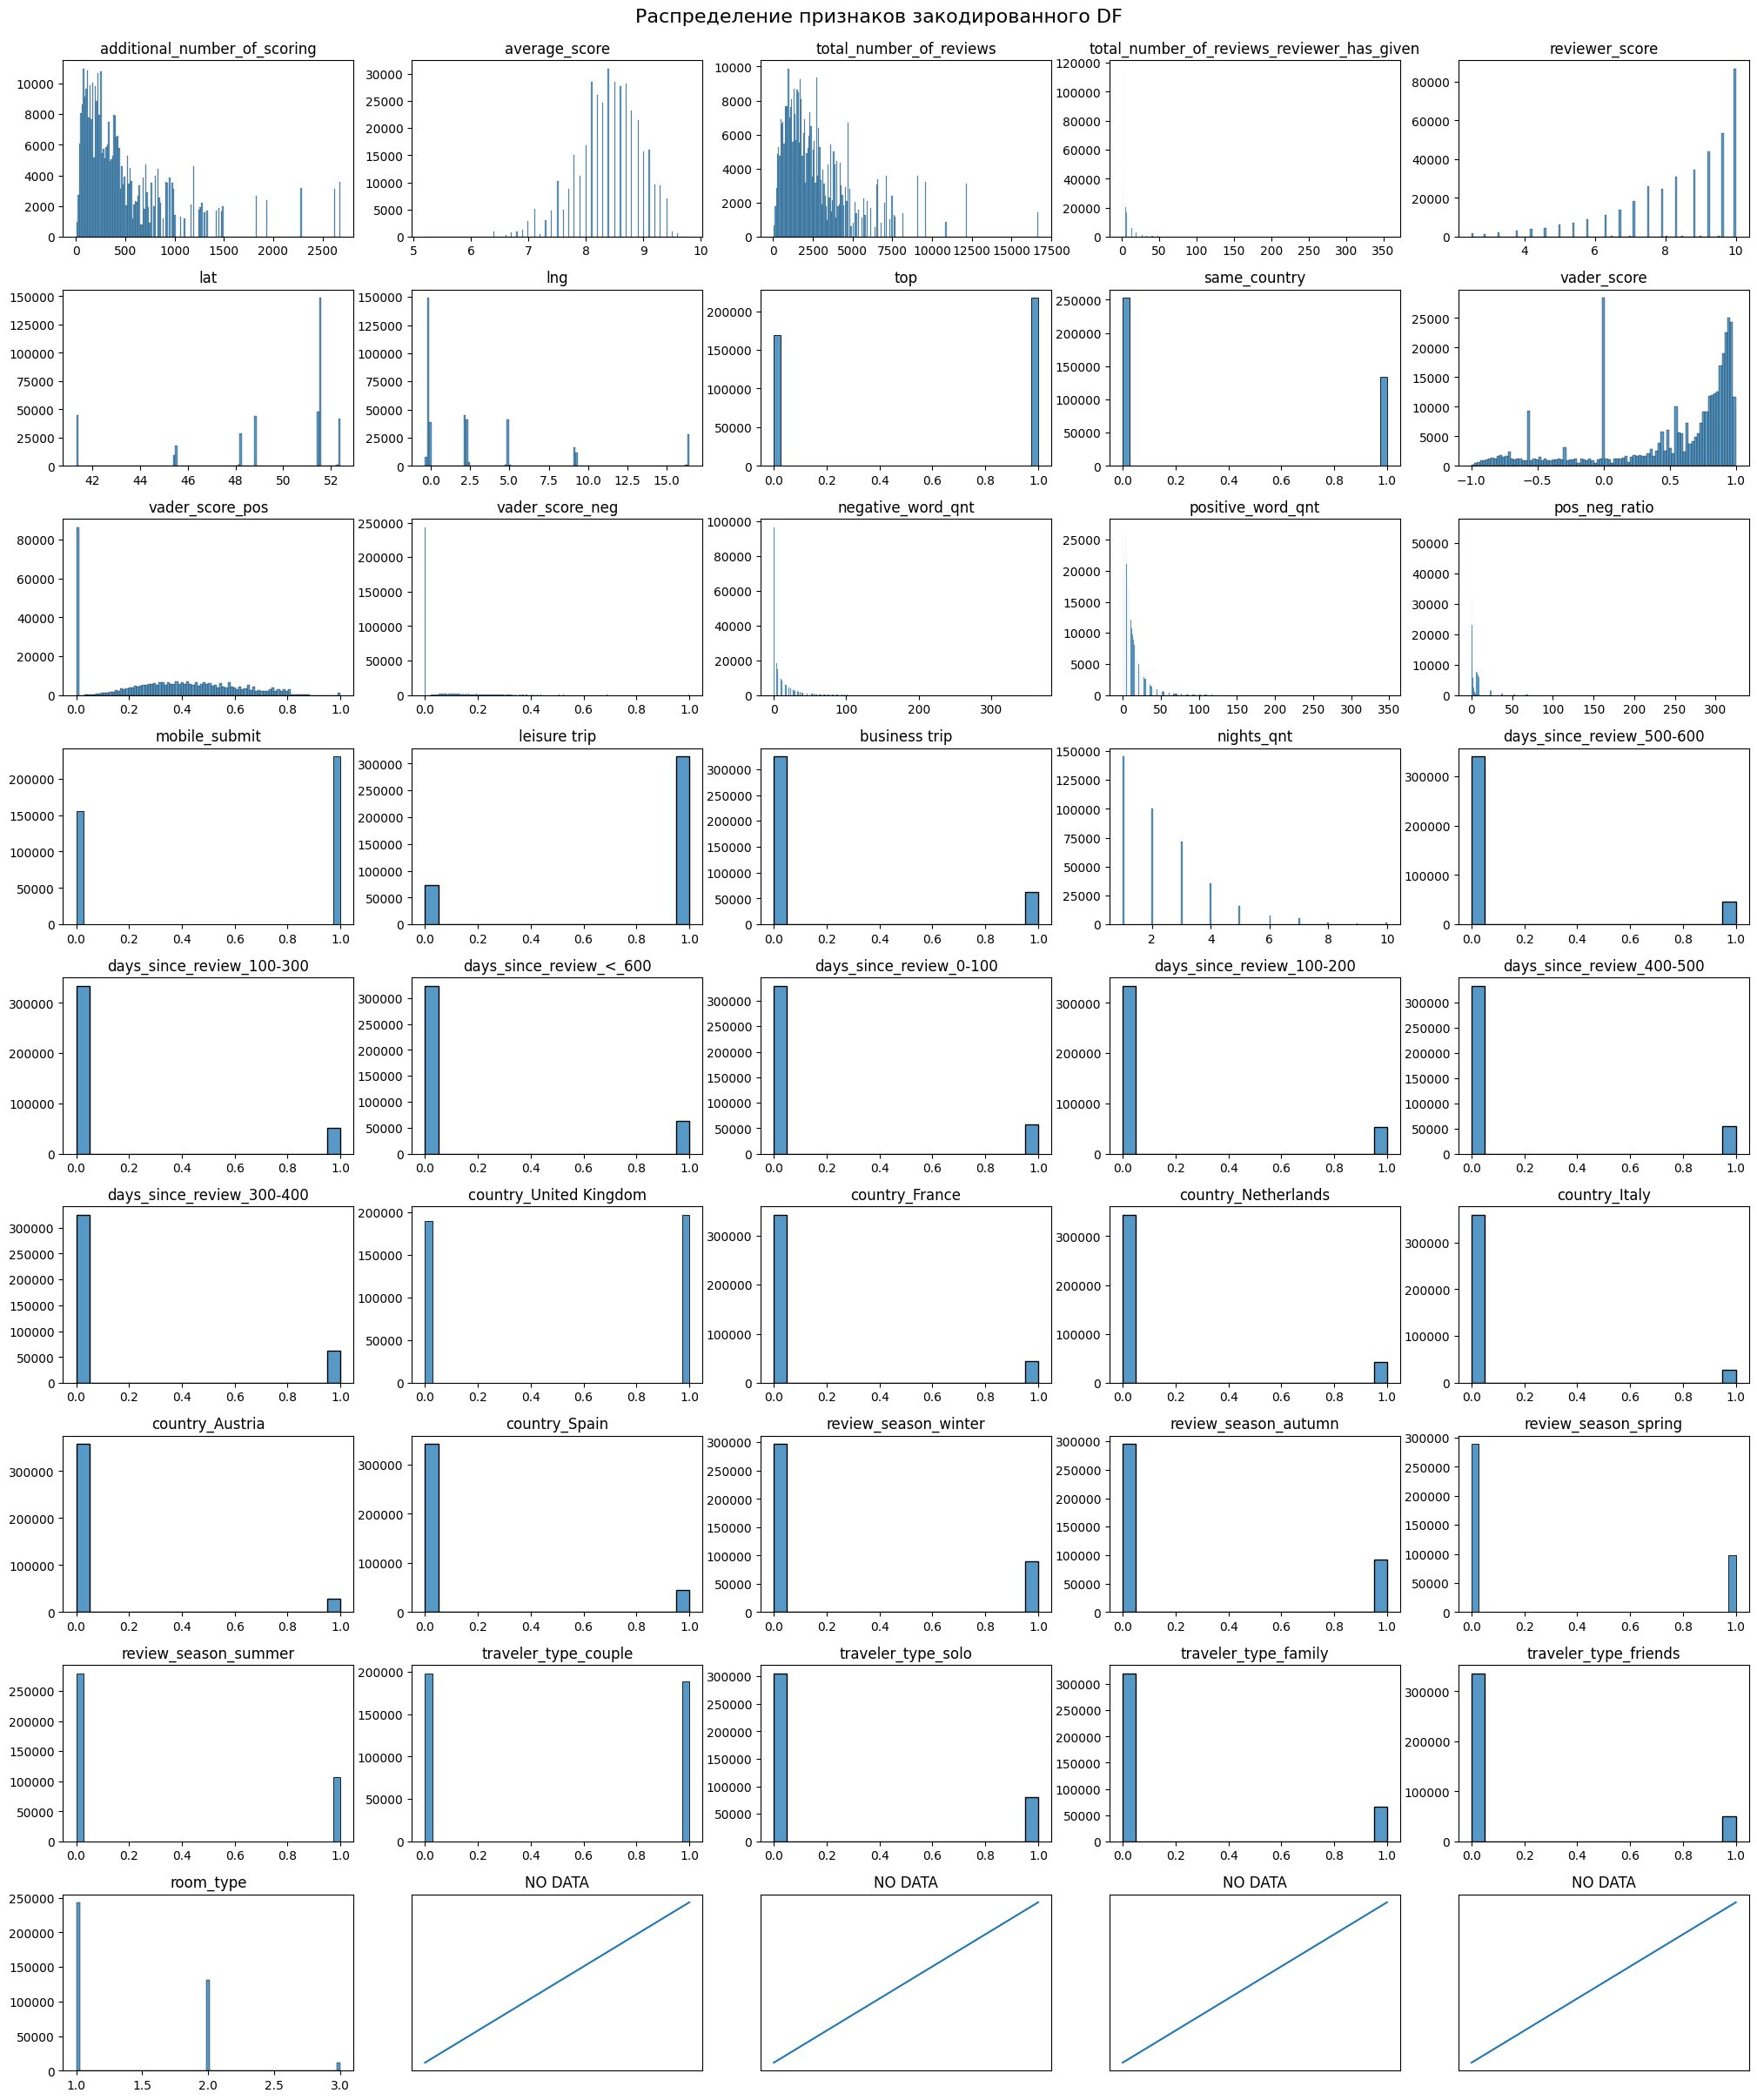

In [44]:
# Задаем subplot и прописываем настройки
fig, axes = plt.subplots(ncols=5, nrows=9, figsize = (25,30))
fig.subplots_adjust(hspace=0.3)

# Построение диаграмм произведем циклом, 
# Задаем переменные строки и столбца для прописания их в позиционировании 
# графика
row = 0
col = 0

for elem in hotels_encode.columns:
    
    hist = sns.histplot(hotels_encode[f'{elem}'], ax=axes[row][col])
    
    hist.set_title(f'{elem}')
    hist.set_xlabel('')
    hist.set_ylabel('')
    
    col += 1
    
    if col == 5:
        col = 0
        row += 1

# Незаполненные графики подпишем и обозначим 
for i in range(4):
        
    data = pd.DataFrame({'x': [0 , 1], 'y': [0, 1]})
    line = sns.lineplot(data=data, x='x', y='y', ax=axes[8][i+1])
    line.set_title('NO DATA')
    line.set_xlabel('')
    line.set_ylabel('')
    line.set_xticks([])
    line.set_yticks([])
        
# Зададим заголовок группе графиков
fig.suptitle('Распределение признаков закодированного DF',
             fontsize = 16,
             y=0.9
             )

fig.show('png')

C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\72296174.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show('png')


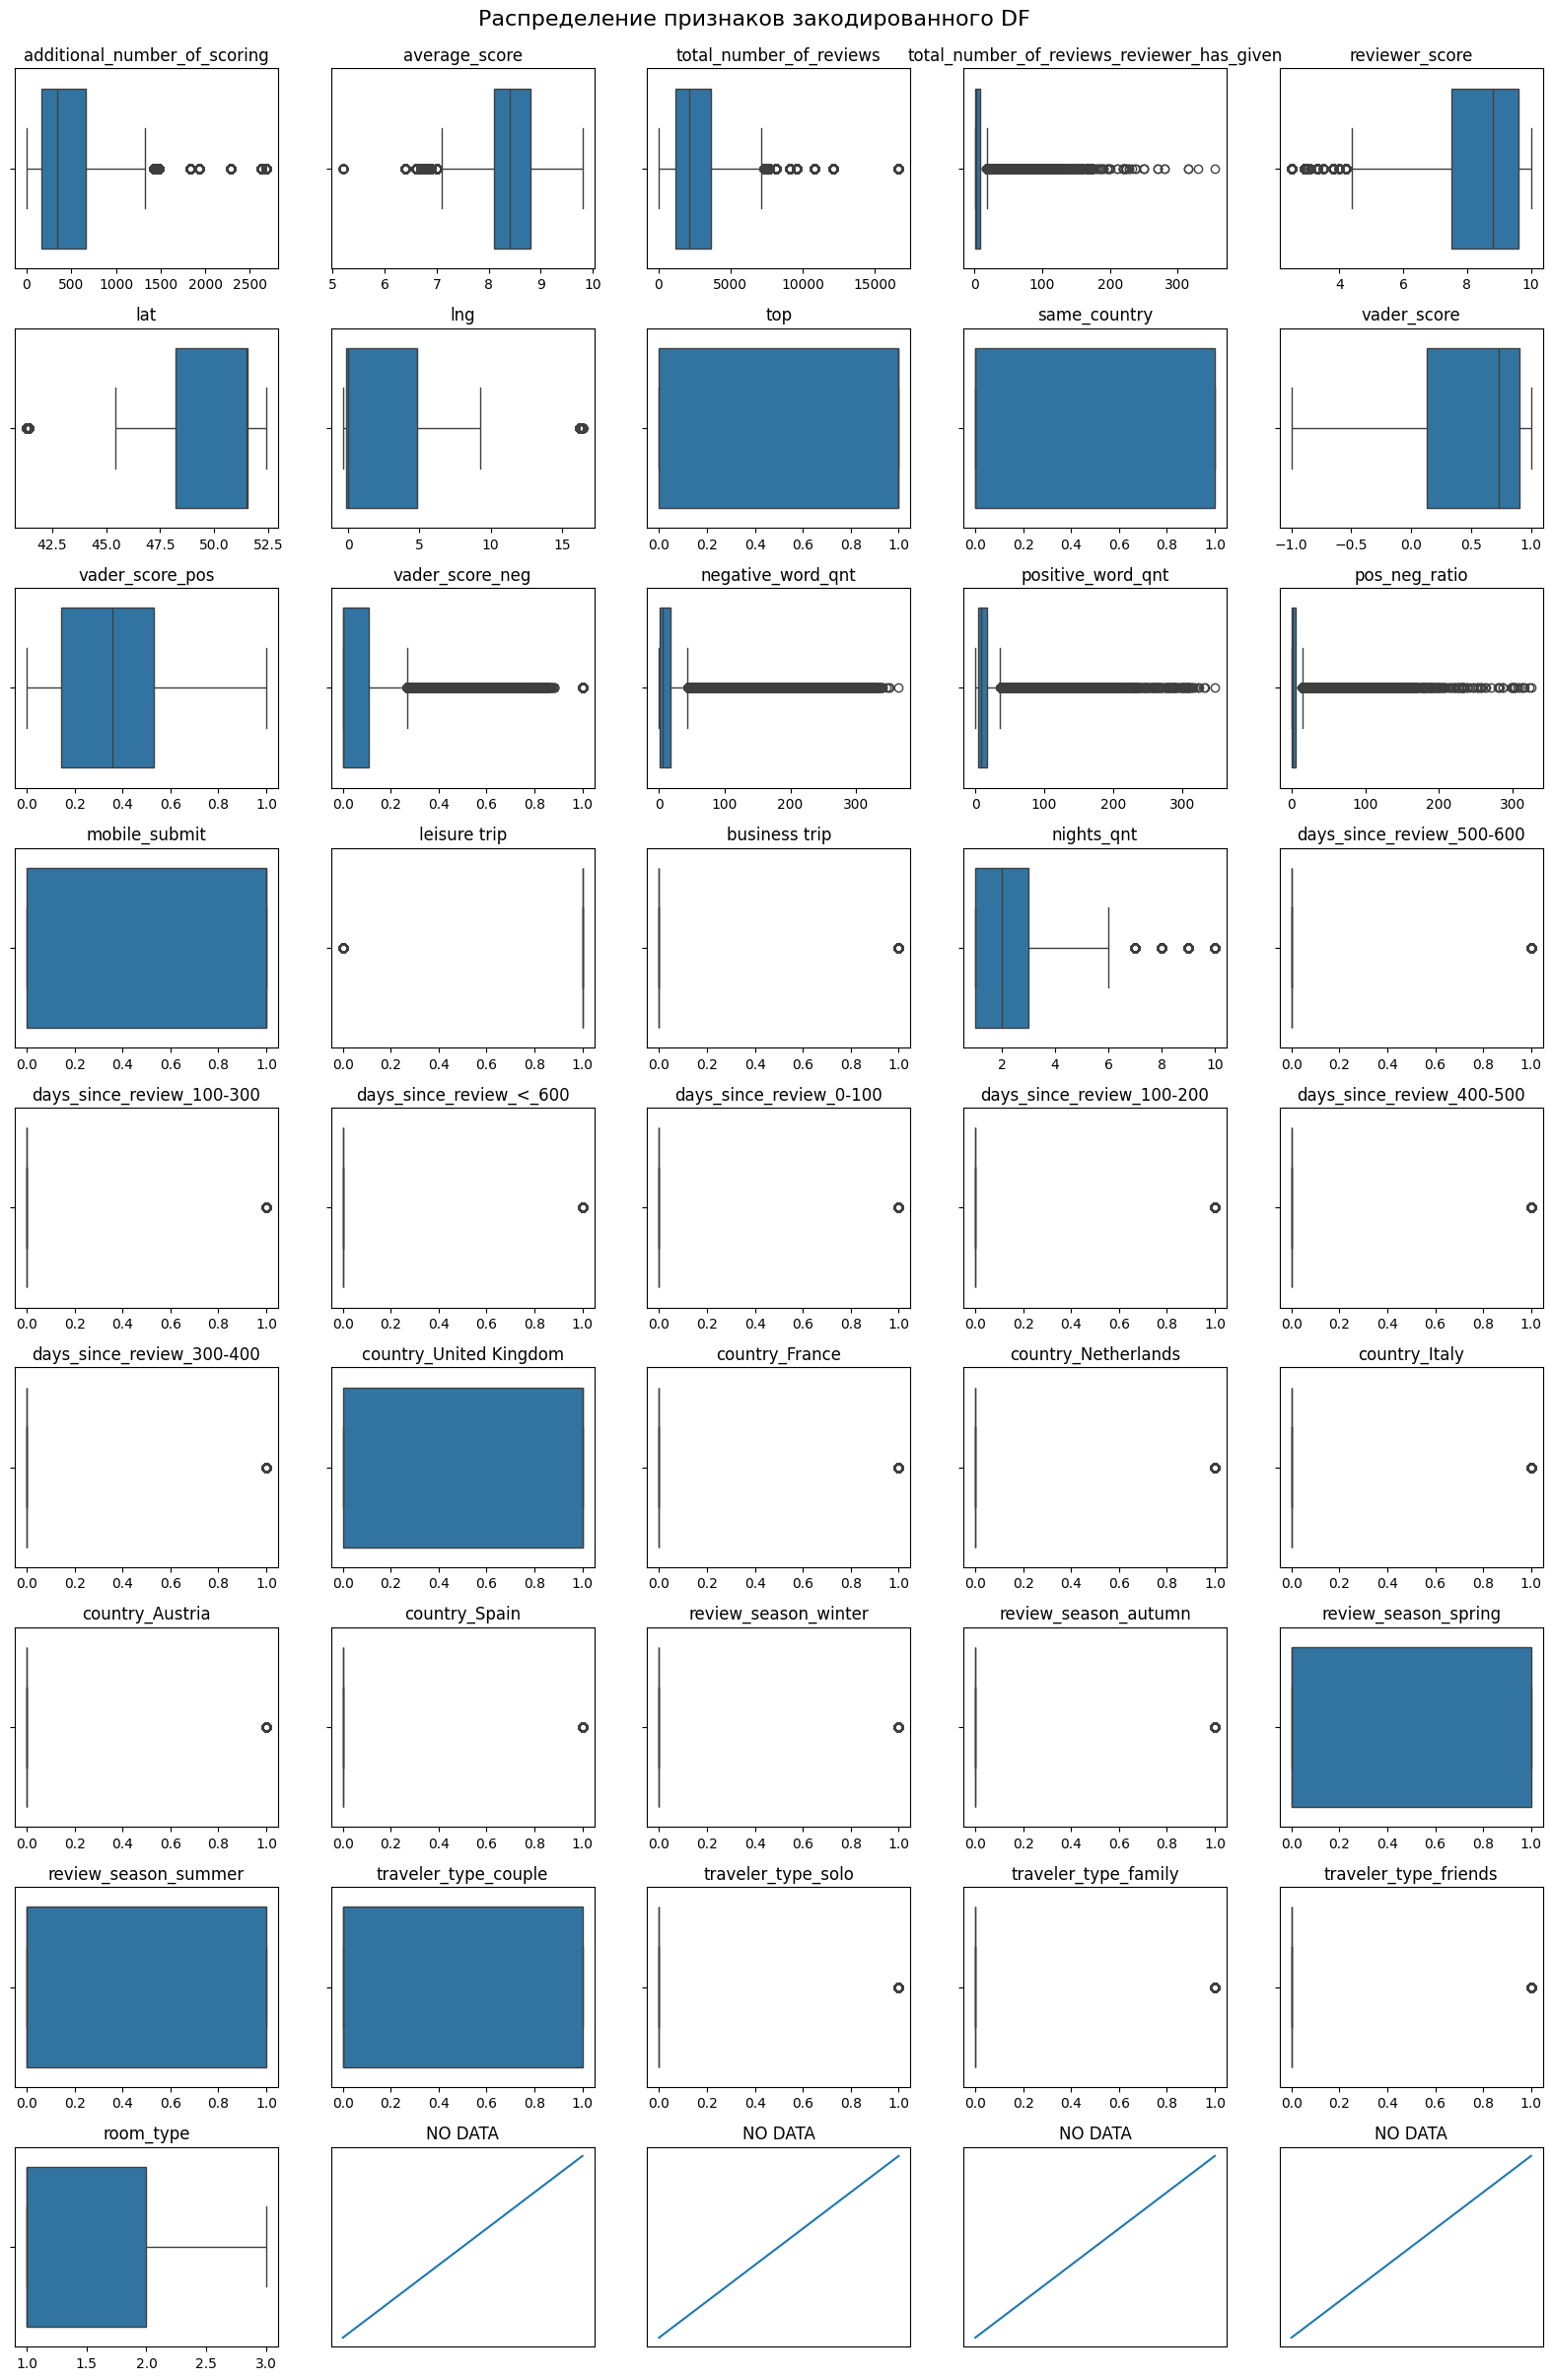

In [45]:
# Задаем subplot и прописываем настройки
fig, axes = plt.subplots(ncols=5, nrows=9, figsize = (20,30))
fig.subplots_adjust(hspace=0.3)

# Построение диаграмм произведем циклом, 
# Задаем переменные строки и столбца для прописания их в позиционировании 
# графика
row = 0
col = 0

for feat in list(hotels_encode.columns):

    box = sns.boxplot(
        hotels_encode[f'{feat}'],
        ax=axes[row][col],
        orient='h',
        )
    box.set_xlabel('')
    box.set_ylabel('')
    box.set_title(f'{feat}')
    
    col += 1
    
    if col == 5:
        col = 0
        row += 1

# Незаполненные графики подпишем и обозначим 
for i in range(4):
        
    data = pd.DataFrame({'x': [0 , 1], 'y': [0, 1]})
    line = sns.lineplot(data=data, x='x', y='y', ax=axes[8][i+1])
    line.set_title('NO DATA')
    line.set_xlabel('')
    line.set_ylabel('')
    line.set_xticks([])
    line.set_yticks([])

# Зададим заголовок группе графиков
fig.suptitle('Распределение признаков закодированного DF', 
             fontsize = 16, va='top', y=0.9
             )

fig.show('png')

C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\4150555815.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show('png')


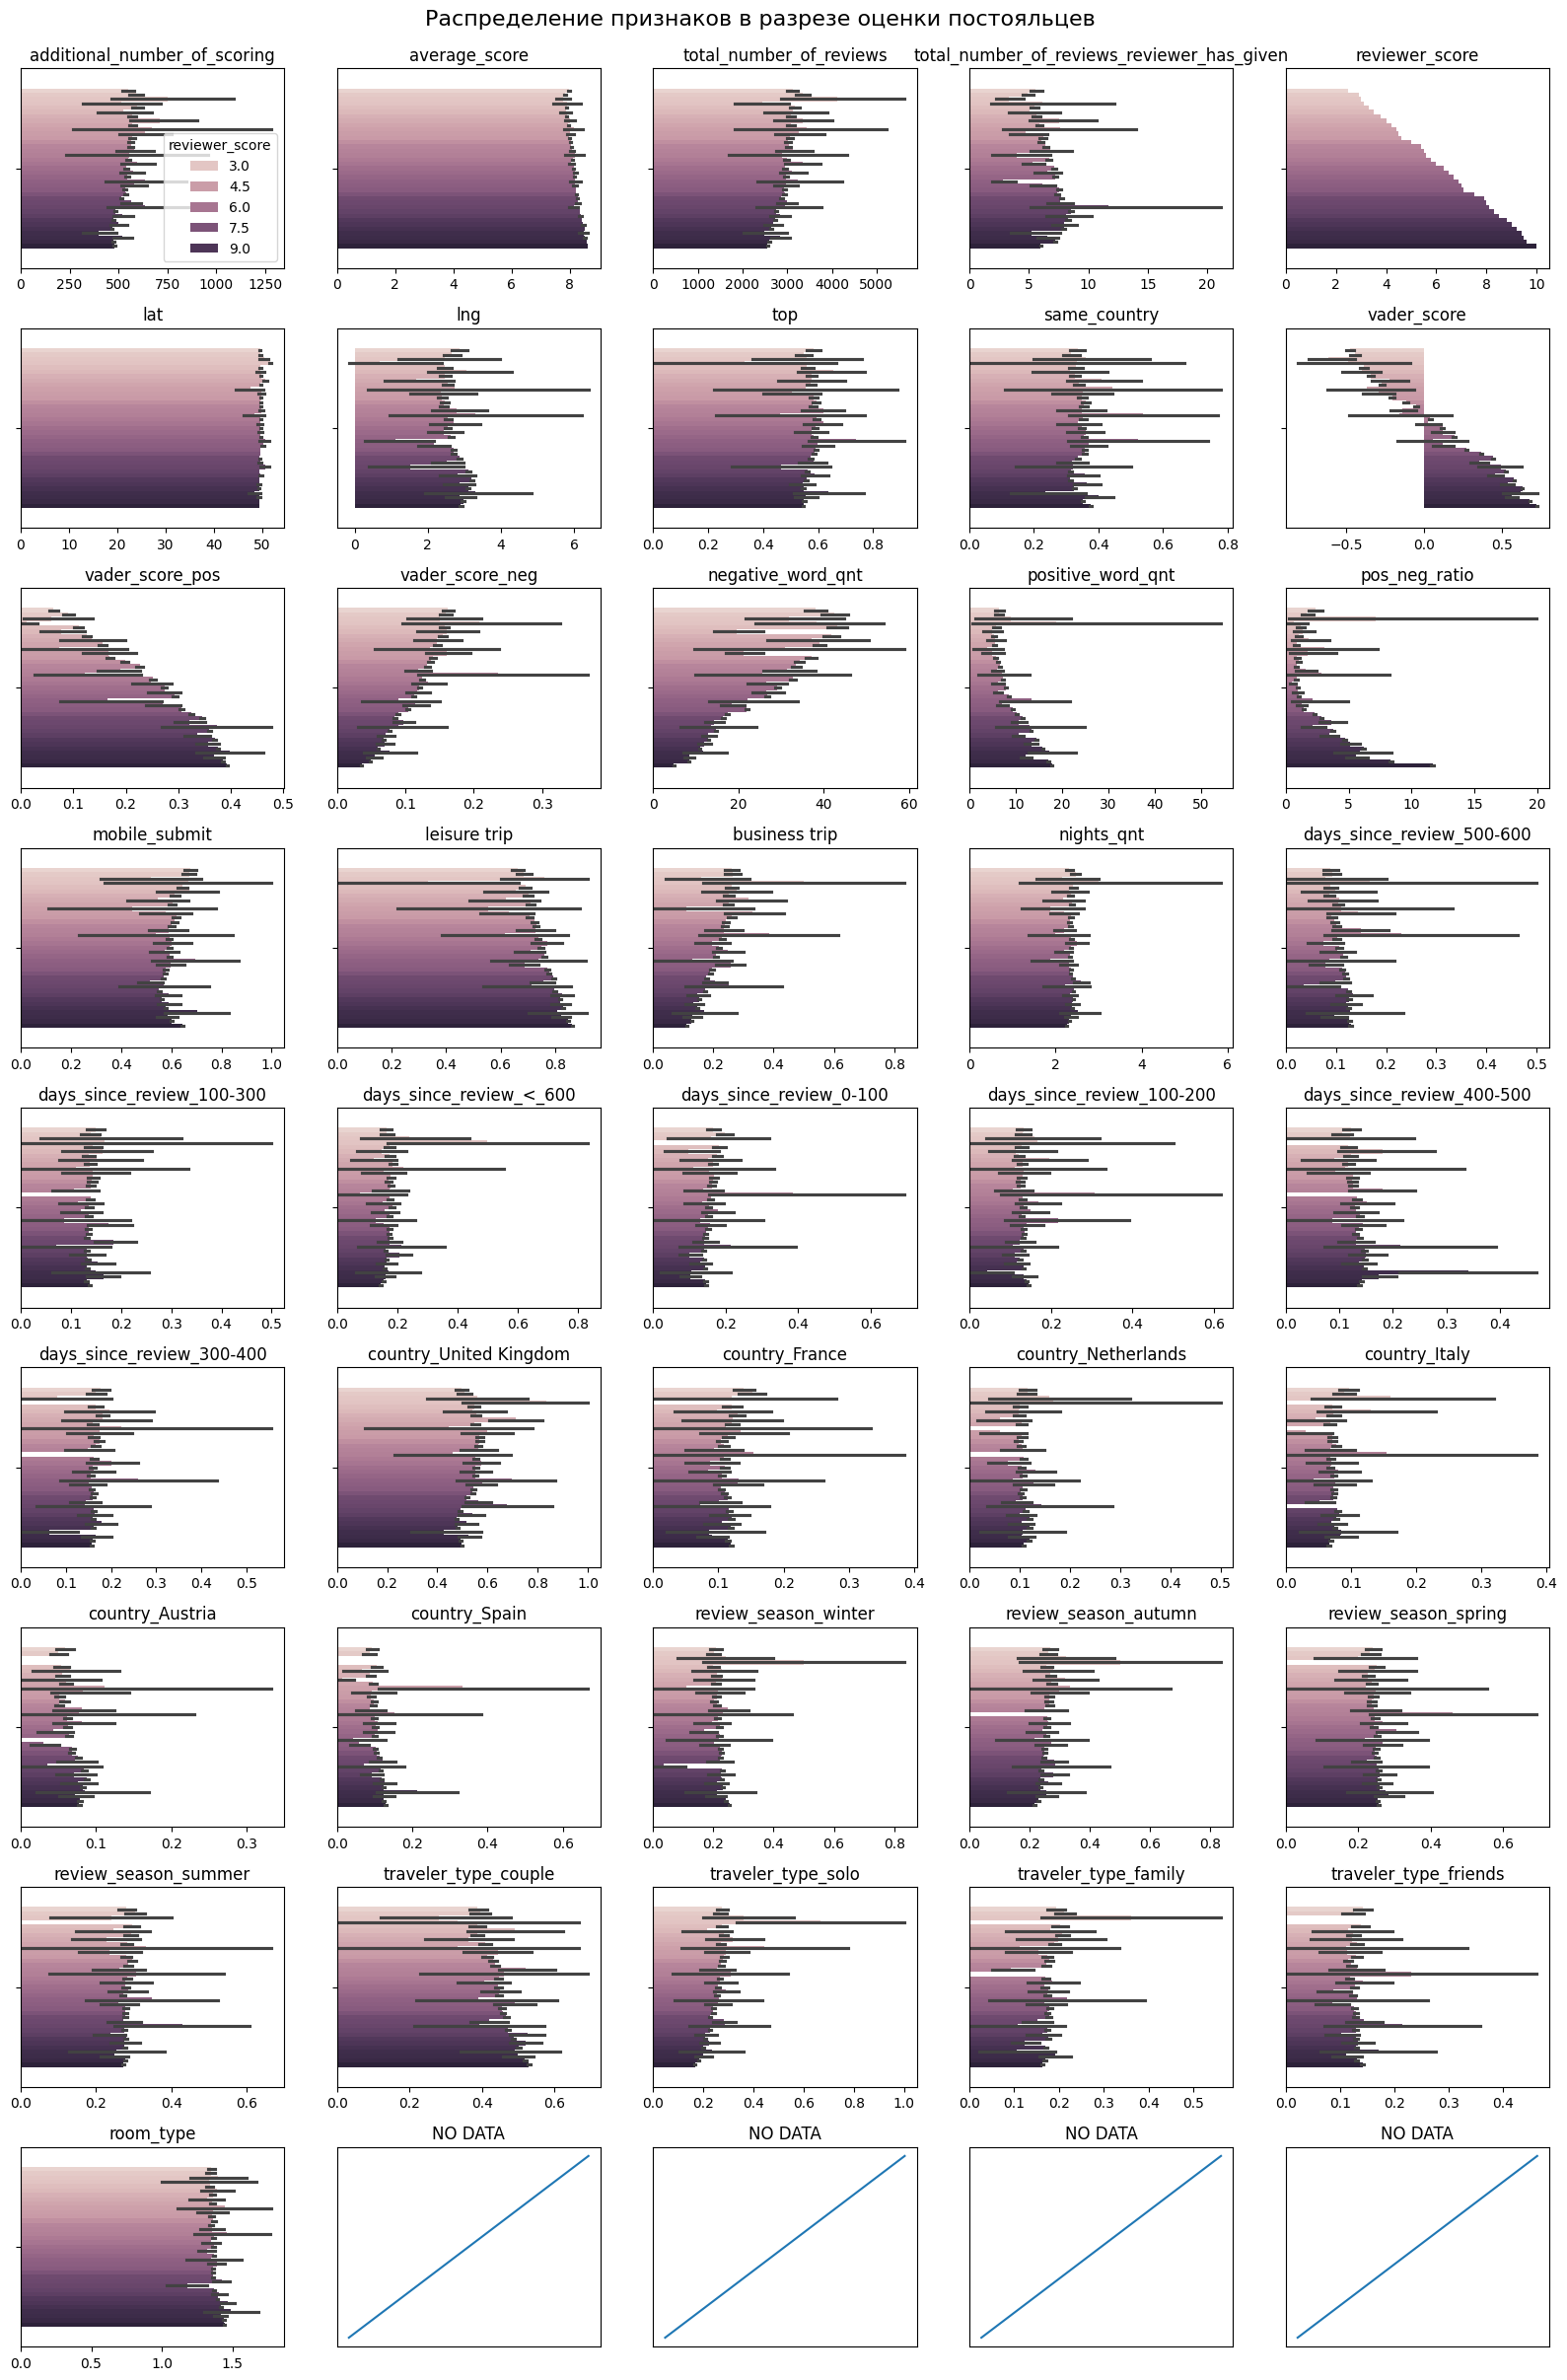

In [46]:
# Задаем subplot и прописываем настройки
fig, axes = plt.subplots(ncols=5, nrows=9, figsize = (20,30))
fig.subplots_adjust(hspace=0.3)

# Построение диаграмм произведем циклом, 
# Задаем переменные строки и столбца для прописания их в позиционировании 
# графика
row = 0
col = 0

for feat in list(hotels_encode.columns):
    
    # Для лучшей читаемости легенду отобразим только на первом 
    # графике, поэтому, сделаем разбивку по условию
    if (row != 0) or (col !=0):
        bar = sns.barplot(
            hotels_encode,
            x = f'{feat}',
            hue = 'reviewer_score',
            ax=axes[row][col],
            orient='h',
            legend=False
            )
        bar.set_title(f'{feat}')
        bar.set_xlabel('')
        bar.set_ylabel('')

    else:
        bar = sns.barplot(
            hotels_encode,
            x = f'{feat}',
            hue = 'reviewer_score',
            ax=axes[row][col],
            orient='h'
            )
        bar.set_title(f'{feat}')
        bar.set_xlabel('')
        bar.set_ylabel('')
    
    col += 1
    
    if col == 5:
        col = 0
        row += 1

# Незаполненные графики подпишем и обозначим 
for i in range(4):
        
    data = pd.DataFrame({'x': [0 , 1], 'y': [0, 1]})
    line = sns.lineplot(data=data, x='x', y='y', ax=axes[8][i+1])
    line.set_title('NO DATA')
    line.set_xlabel('')
    line.set_ylabel('')
    line.set_xticks([])
    line.set_yticks([])

# Зададим заголовок группе графиков
fig.suptitle('Распределение признаков в разрезе оценки постояльцев', 
             fontsize = 16, y=0.9
             )

fig.show('png')

**Наблюдения:**

Из построенных гистограмм мы видим, что нормально распределенных данных нет.
Из построенных коробчатых диаграмм мы видим, что есть ряд признаков с очень большим количеством выбросов. 
Из построенных столбчатых диаграмм мы можем заметить, что ряд признаков связаны с прогнозируемым признаком, какие-то признаки, как пример, negative_word_qnt, vader_score имеют прямую связь. 

___
## Отбор признаков

В ходе построения коробчатых диаграмм выше, мы отметили, что есть признаки, влияние которых на прогнозируемый признак видно невооруженным глазом, а есть часть признаков, которые, на первый взгляд не окызывают ни какого влияния. 

Произведем оценку влияния признаков "более научно", при помощи библиотеки sklearn и метода f_classif.

In [47]:
from sklearn.feature_selection import f_classif # anova

# Разделение на два массива данных, на прогнозируемый признак 
# и на остальные признаки для определения их влияния
X = hotels_encode.drop(['reviewer_score'], axis = 1)
y = hotels_encode['reviewer_score']
y=y.astype('int')

# Создаем список числовых признаков (на данном этапе все наши признаки числовые)
num_cols = list(hotels_encode.columns)

# Удаление колонки reviewer_score
num_cols.remove('reviewer_score')

# Создание series с оценкой влияния признака
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace = True)

# Создание DF на основе объекта Series
imp_num_df = pd.DataFrame(imp_num)
imp_num_df = imp_num_df.reset_index()
imp_num_df = imp_num_df.rename(columns={'index' : 'feature', 0 : 'impact'})
imp_num_df = imp_num_df.sort_values(by='impact', ascending=False)
imp_num_df = imp_num_df.reset_index().drop('index', axis=1)

# Отобразим получившийся DF с наименование признака и оценкой его влияния
display(imp_num_df)


,feature,impact
0,vader_score,17413.780532
1,negative_word_qnt,8205.158305
2,average_score,7588.683414
3,pos_neg_ratio,5495.210032
4,vader_score_pos,3396.931309
5,vader_score_neg,2950.293520
6,positive_word_qnt,2468.461480
7,leisure trip,675.163202
8,business trip,633.185389
9,traveler_type_solo,357.846542


Как мы отметили ранее, наибольшее влияние оказывают признаки vader_score, negative_word_qnt. Причем влияние созданного на этапе проектирования признака vader_score "на голову выше", чем исходные признаки DF.

Поступи следующим образом, создадим список признаков, оценка влияния которых более чем 150 (таким образом у нас будет 16 признаков против 39 всего), которые мы подадим на модель. 

In [48]:
# Создание списка, наиболее влияющих признаков
top_list = list(
    imp_num_df[imp_num_df['impact'] >150]['feature'].value_counts().index
    )

# Добавление в список прогнозируемого признака (на основе списка создадим DF для модели)
top_list.append('reviewer_score')

___
## Нормализация признаков 

На построенных гистограммах и коробчатых диаграммах мы видели, что распределение данных далеко от идеального. Для дальнейшего улучшения данных для моделей можно попробовать прибегнуть к нормализации и стандартизации данных. 

Для наглядности, на данном этапе ограничемся работой с признаками со значениями примерно одного порядка. В случае построения графиков с учетом, например, признака total_numbers_of_reviews, значения которого исчисляются тысячами, мы не получим наглядности. 

В дальнешей мы применим эти приемы ко всем данным. Но, на данном этапе речь идет именно о наглядяности. Воспользуемся методом визуализации kdeplot().

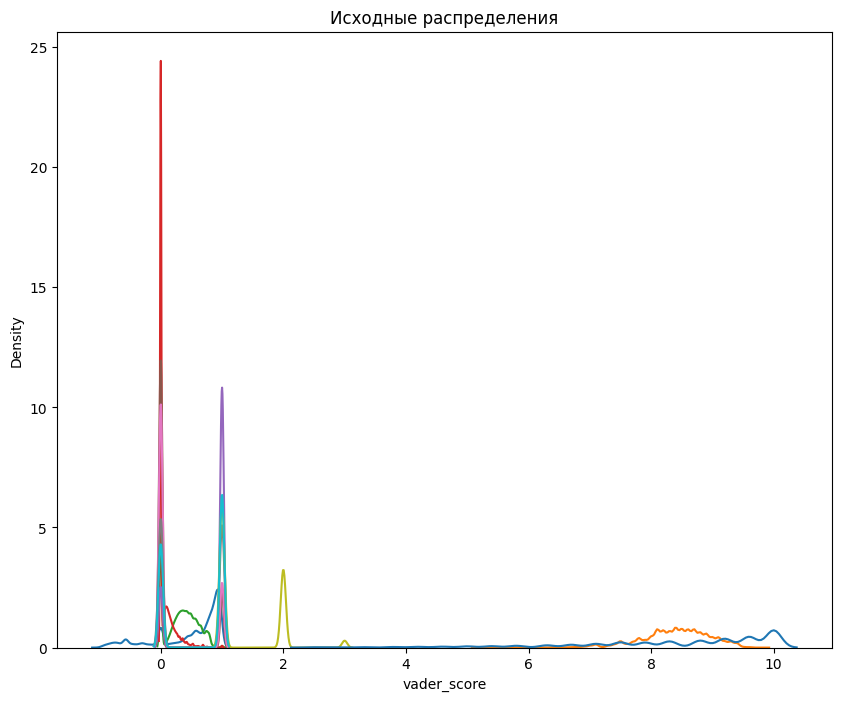

In [49]:
# Создаем список признаков, распределения которых будем строить
# Это копия списка наиболее влиятельных признаков.
list_to_kde = top_list.copy()

# Очистим список от признаков с большими значениями
list_to_kde.remove('total_number_of_reviews')
list_to_kde.remove('additional_number_of_scoring')
list_to_kde.remove('negative_word_qnt')
list_to_kde.remove('pos_neg_ratio')
list_to_kde.remove('positive_word_qnt')
list_to_kde.remove('total_number_of_reviews_reviewer_has_given')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

for feat in list_to_kde:
    sns.kdeplot(hotels_encode[f'{feat}'], ax=ax1, label =f'{feat}')

Создадим копию DF, данные в котором мы будем нормализовывать и стандартизировать. 

In [50]:
df = hotels_encode[list_to_kde].copy()

Произведем нормализацию. Ввиду того, что наши данные богаты на выбросы, воспользуемся методом RobustScaler.

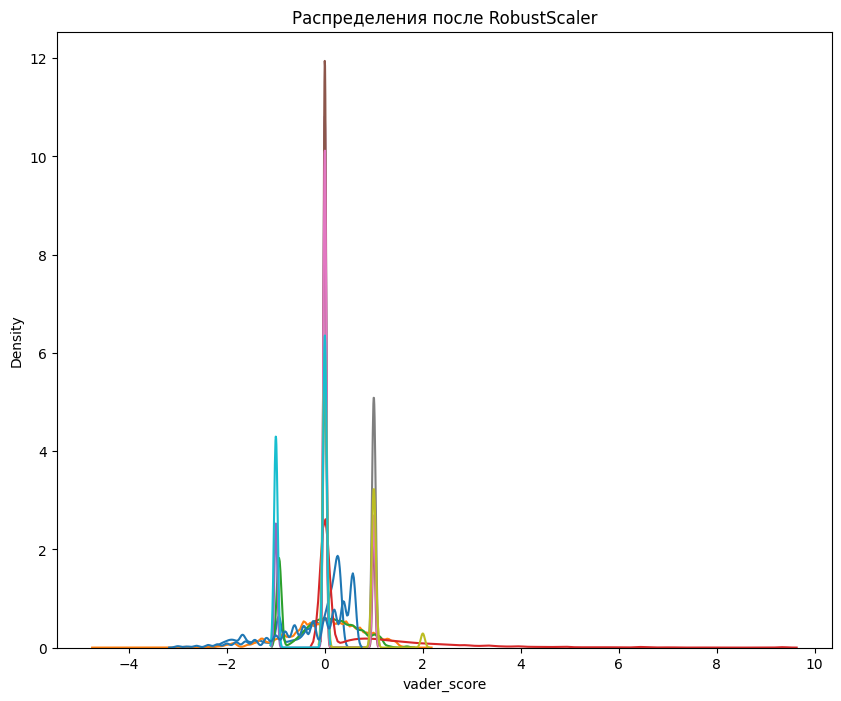

In [51]:
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=list_to_kde)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

for feat in list_to_kde:
    sns.kdeplot(df_r[f'{feat}'], ax=ax1, label =f'{feat}')

После нормализации произведем стандартизацию. 

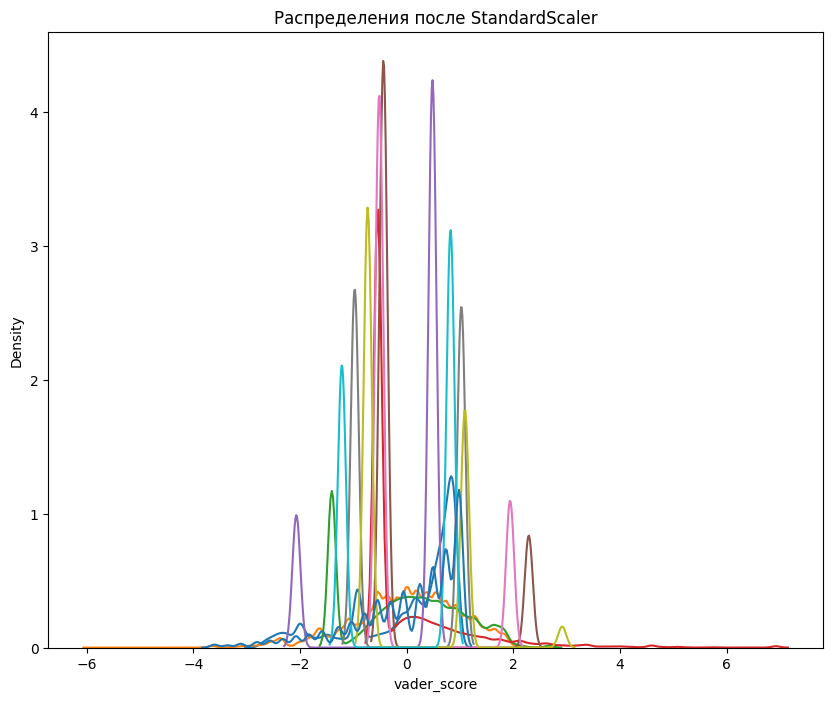

In [52]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
df_s = s_scaler.fit_transform(df_r)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=list_to_kde)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

for feat in list_to_kde:
    sns.kdeplot(df_s[f'{feat}'], ax=ax1, label =f'{feat}')

Мы видим, что распределение данных имеет более приемлемую структуру на данном этапе. 

## Подготовка DF для модели

Так как наша задача получить максимально высокую оценку работы нашей модели, нам надо поэксперементировать. 

Для этого, на модель должны быть поданы разные данные и должна быть зафиксирована оценка по каждому DF, поданному на модель. 

Подготовим следующие DF: 
1) Закодированный DF со всеми признаками (уже готов)
2) Закодированный DF со всеми признаками с нормализованными значениями признаков 
3) Закодированный DF со всеми признаками с нормализованными и стандартизированными значениями признаков 
4) Закодированный DF с наиболее влиятельными признаками
5) Закодированный DF с наиболее влиятельными признаками с нормализованными значениями признаков
6) Закодированный DF с наиболее влиятельными признаками с нормализованными и стандартизированными значениями признаков

In [53]:
# инициализируем стандартизатор StandardScaler
r_scaler = preprocessing.RobustScaler()

# трансформируем исходный датасет (закодированный)
hotels_encode_norm = r_scaler.fit_transform(hotels_encode)

# Преобразуем промежуточный датасет в полноценный датафрейм
hotels_encode_norm = pd.DataFrame(
    hotels_encode_norm, 
    columns = list(hotels_encode.columns)
    )

In [54]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# трансформируем исходный датасет
hotels_encode_norm_stnd = s_scaler.fit_transform(hotels_encode_norm)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_encode_norm_stnd = pd.DataFrame(
    hotels_encode_norm_stnd, 
    columns = list(hotels_encode.columns)
    )

In [55]:
# Признак reviewer_score так же преобразован, 
# Восстановим его исходные данные, удалим, и добавим из закодированного DF
hotels_encode_norm = hotels_encode_norm.drop(
    ['reviewer_score'], axis=1
    )

hotels_encode_norm = pd.concat(
    [hotels_encode_norm, hotels_encode['reviewer_score']],
    axis=1
    )

In [56]:
# Признак reviewer_score так же преобразован, 
# Восстановим его исходные данные, удалим, и добавим из закодированного DF
hotels_encode_norm_stnd = hotels_encode_norm_stnd.drop(
    ['reviewer_score'], axis=1
    )

hotels_encode_norm_stnd = pd.concat(
    [hotels_encode_norm_stnd, hotels_encode['reviewer_score']],
    axis=1
    )

In [57]:
hotels_encode_top = hotels_encode[top_list].copy()

In [58]:
# инициализируем стандартизатор StandardScaler
r_scaler = preprocessing.RobustScaler()

# трансформируем исходный датасет (закодированный)
hotels_encode_top_norm = r_scaler.fit_transform(hotels_encode_top)

# Преобразуем промежуточный датасет в полноценный датафрейм
hotels_encode_top_norm = pd.DataFrame(
    hotels_encode_top_norm, 
    columns = list(hotels_encode_top.columns)
    )

In [59]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# трансформируем исходный датасет
hotels_encode_top_norm_stnd = s_scaler.fit_transform(hotels_encode_top_norm)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_encode_top_norm_stnd = pd.DataFrame(
    hotels_encode_top_norm_stnd, 
    columns = list(hotels_encode_top.columns)
    )

In [60]:
# Признак reviewer_score так же преобразован, 
# Восстановим его исходные данные, удалим, и добавим из закодированного DF
hotels_encode_top_norm = hotels_encode_top_norm.drop(
    ['reviewer_score'], axis=1
    )

hotels_encode_top_norm = pd.concat(
    [hotels_encode_top_norm, hotels_encode['reviewer_score']],
    axis=1
    )

In [61]:
# Признак reviewer_score так же преобразован, 
# Восстановим его исходные данные, удалим, и добавим из закодированного DF
hotels_encode_top_norm_stnd = hotels_encode_top_norm_stnd.drop(
    ['reviewer_score'], axis=1
    )

hotels_encode_top_norm_stnd = pd.concat(
    [hotels_encode_top_norm_stnd, hotels_encode['reviewer_score']],
    axis=1
    )

И так, мы имеем 6 DF, которые будут поданы на модель машинного обучения. Вот они: 

1) hotels_encode
2) hotels_encode_norm
3) hotels_encode_norm_stnd
4) hotels_encode_top
5) hotels_encode_top_norm
6) hotels_encode_top_norm_stnd

In [62]:
# Список DF для подачи на модель 
df_list = [
    hotels_encode,
    hotels_encode_norm,
    hotels_encode_norm_stnd,
    hotels_encode_top,
    hotels_encode_top_norm,
    hotels_encode_top_norm_stnd
    ]

df_list_str = [
    'hotels_encode',
    'hotels_encode_norm',
    'hotels_encode_norm_stnd',
    'hotels_encode_top',
    'hotels_encode_top_norm',
    'hotels_encode_top_norm_stnd'
    ]


## Модель машинного обучения

In [63]:
# Создаем DF, в который будем заносить результаты работы модели, 
# название DF, на котором обучалась модель, оценку ее прогноза и время обучения
df_mape = pd.DataFrame(columns=['df_name', 'MAPE', 'elapsed_time'])

from timeit import default_timer as timer
from datetime import timedelta

# Циклом сделаем обучение моделей на разных DF
for i, df in enumerate(df_list):
    
    # Задаем время старта обучения
    start = timer()

    # Делим данные на прогнозируемые значения и остальные
    X = df.drop(['reviewer_score'], axis = 1)  
    y = df['reviewer_score'] 

    # Метод для деления данных на категории
    from sklearn.model_selection import train_test_split  

    # 4 категории 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
        )

    # инструмент для создания и обучения модели  
    from sklearn.ensemble import RandomForestRegressor 
    
    # инструменты для оценки точности модели 
    from sklearn import metrics 

    # модель
    regr = RandomForestRegressor(n_estimators=100)  
        
    # Обучаем модель на тестовом наборе данных  
    regr.fit(X_train, y_train)  
        
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
    y_pred = regr.predict(X_test)  

    # Коэфициент оценки эффективности
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    
    # Задаем время окончания обучения
    end = timer()
    
    # Затраченное время на обучение модели
    elapsed_time = timedelta(seconds=end-start)
    
    # Заносим данные и метрики в DF
    df_mape.loc[len(df_mape)] = [f'{df_list_str[i]}', mape, f'{elapsed_time}']

In [ ]:
# Создаем вспомогательный признак-копию времени
df_mape['elapsed_time_copy'] = df_mape['elapsed_time']

# Прообразуем значения в формат datetime, и, затем в timedelta
df_mape['elapsed_time_copy'] = pd.to_datetime(df_mape['elapsed_time_copy'])
df_mape['elapsed_time_copy'] = pd.to_timedelta(
    df_mape['elapsed_time']
    ).dt.total_seconds()

# Введем новый признак, на сколько процентов прогноз модели с 
# определенного DF хуже, чем лучший прогноз
df_mape['MAPE_over_%'] = df_mape['MAPE'].apply(
    lambda x: 'BEST' if x == df_mape['MAPE'].min()
    else 
    ( (x - df_mape['MAPE'].min()) / df_mape['MAPE'].min() ) * 100
    )

# Введем новый признак, показывающий на сколько время обучения 
# модели на определенном DF больше, чем лучшее время  
df_mape['longer_then_best_sec'] = df_mape['elapsed_time_copy'].apply(
    lambda x: 'BEST' if x == df_mape['elapsed_time_copy'].min()
    else
    (x - df_mape['elapsed_time_copy'].min())
    )

# Удалим вспомогательный признак 
df_mape = df_mape.drop(['elapsed_time_copy'], axis=1)

C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\3321823057.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mape['elapsed_time_copy'] = pd.to_datetime(df_mape['elapsed_time_copy'])


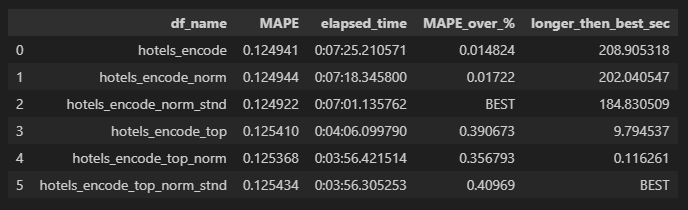

Итак, наивысшую оценку MAPE получила модель, обученная на полном перечне закодированных данных, прошедших нормализацию и стандартизацию. Помимо лучшего показателя MAPE, нормализованные и стандартизированные данные помогли модели обучиться на 24 секунды быстрее, чем на DF с данными, не проходящими данную обработку, то есть, она обучилась на 5 процентов быстрее.

Худшие показатели MAPE у моделей, обученных на DF с отобранными признаками, потеря в качестве прогноза 0,36..0,41 процента. 

Но, зато благодаря меньшему количеству признаков, на которых обучалась модель, существенно сократилось время ее обучения. Лучшая модель по времени обучения (DF с отобранными, стандартизированными и нормализованными данными) обучилась быстрее лучшей модели по MAPE на 185 секунд быстрее. Если оперировать относительными величинами, то она обучилась на 44 процента быстрее. Но, как сказано выше, точность ее прогнозов ниже на 0,4 процента. 

Исходя из того, что абсолютное время обучения лучшей по MAPE модели составляет 7 минут 1 секунду, то, не смотря на относительную "медленность", можно принять, что данный вариант предпочтительнее. 

___
# Модели для тестовых данных

Подготовим три модели, занявшие лучше показатели по метрике MAPE. 

regr_encode, regr_encode_norm, regr_encode_norm_std

In [66]:
# Делим данные на прогнозируемые значения и остальные
X = hotels_encode.drop(['reviewer_score'], axis = 1)  
y = hotels_encode['reviewer_score'] 

# Метод для деления данных на категории
from sklearn.model_selection import train_test_split  

# 4 категории 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )

# модель
regr_encode = RandomForestRegressor(n_estimators=100)  
    
# Обучаем модель на тестовом наборе данных  
regr_encode.fit(X_train, y_train)  
    
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr_encode.predict(X_test)  

# Коэфициент оценки эффективности
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('MAPE:', mape)

MAPE: 0.12516583350031857


In [67]:
# Делим данные на прогнозируемые значения и остальные
X = hotels_encode_norm.drop(['reviewer_score'], axis = 1)  
y = hotels_encode_norm['reviewer_score'] 

# Метод для деления данных на категории
from sklearn.model_selection import train_test_split  

# 4 категории 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )

# модель
regr_encode_norm = RandomForestRegressor(n_estimators=100)  
    
# Обучаем модель на тестовом наборе данных  
regr_encode_norm.fit(X_train, y_train)  
    
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr_encode_norm.predict(X_test)  

# Коэфициент оценки эффективности
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('MAPE:', mape)

MAPE: 0.12487945488230018


In [68]:
# Делим данные на прогнозируемые значения и остальные
X = hotels_encode_norm_stnd.drop(['reviewer_score'], axis = 1)  
y = hotels_encode_norm_stnd['reviewer_score'] 

# Метод для деления данных на категории
from sklearn.model_selection import train_test_split  

# 4 категории 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )

# модель
regr_encode_norm_std = RandomForestRegressor(n_estimators=100)  
    
# Обучаем модель на тестовом наборе данных  
regr_encode_norm_std.fit(X_train, y_train)  
    
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr_encode_norm_std.predict(X_test)  

# Коэфициент оценки эффективности
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('MAPE:', mape)

MAPE: 0.12504738014770914


___
## Обработка тестовых данных 

Обработку произведем в той же последовательности, что и обработку данных датасета выше. 

Все пояснения и промежуточные выводы будут отсутствовать.

In [69]:
# Чтение DF
hotels_t = pd.read_csv('data/hotels_test.csv')

In [70]:
# Проверка данных
hotels_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Имеются пропуски по lat и lng. Ручной метод, примененный изначально применять не будем. 
Пропишем медианную по стране. 
Для начала сделаем преобразование признаков, создавая признак страны.  

In [71]:
# Пропишем функцию для извлечения страны из признака адреса отеля
def country_extract(string):
    country = list(string.split(' '))[-1]
    return country

# Создадим новый признак страны отеля, применив функцию к адресу
hotels_t['country'] = hotels_t['hotel_address'].apply(country_extract)

# По результату получили одно из значений 'Kingdom', 
# Напишем функцию, дающую полное название страны
hotels_t['country'] = hotels_t['country'].apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x
    )

# Удалим признак адреса, он для модели не пригоден 
hotels_t = hotels_t.drop('hotel_address', axis=1)


In [72]:
# Создание DF с списком стран и средним значением широты
data_lat = pd.DataFrame(
    hotels_t.groupby('country')['lat'].mean())

# Создание DF с списком стран и средним значением долготы
data_lng = pd.DataFrame(
    hotels_t.groupby('country')['lng'].mean())

# Заполним пропуски словами-маркерами, по ним будем перезаполнять
hotels_t['lat'] = hotels_t['lat'].fillna('toreplacelat')
hotels_t['lng'] = hotels_t['lng'].fillna('toreplacelng')

# Переименуем оригинальные названия признаков 
# В дальнейшем их удалим, после создания новых
hotels_t = hotels_t.rename(columns={'lat': 'lat_orig', 'lng': 'lng_orig'})

# Функция заполнения пропусков по "маркерам" - долгота
# Если слово маркер - заменяем средним по стране, 
# Если признак заполнен, оставляем его значение
def lat_filling(col_country, col_lat):
    if col_lat == 'toreplacelat':
        result = data_lat.loc[f'{col_country}'][0]
    else:
        result = col_lat
    return result

# Создание признака долготы
hotels_t['lat'] = hotels_t.apply(
    lambda x: lat_filling(x.country, x.lat_orig), axis=1
    )

# Функция заполнения пропусков по "маркерам" - широта
# Если слово маркер - заменяем средним по стране, 
# Если признак заполнен, оставляем его значение
def lng_filling(col_country, col_lng):
    if col_lng == 'toreplacelng':
        result = data_lng.loc[f'{col_country}'][0]
    else:
        result = col_lng
    return result

# Создание признака широты
hotels_t['lng'] = hotels_t.apply(
    lambda x: lng_filling(x.country, x.lng_orig), axis=1
    )

# Удаляем ненужные признаки, в которых есть пропуски
hotels_t = hotels_t.drop(['lat_orig', 'lng_orig'], axis=1)

C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\4061079087.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result = data_lat.loc[f'{col_country}'][0]
C:\Users\nitys\AppData\Local\Temp\ipykernel_122104\4061079087.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result = data_lng.loc[f'{col_country}'][0]


Пропуски заполнены, вернемся к исходной последовательности преобразования DF

In [73]:
# Произведем чтение DF
url='https://drive.google.com/file/d/1ATDWtM5RP-OtiFLUuePr5VGzcP3Cpdtx/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
top_50_world_df = pd.read_csv(url, encoding='latin-1')

# Пустой список, куда занесем отдельные слова из названий отелей
top_50_world_list = []

# Функция для извлечения слов из названий отелей
def top_50_name_extract(name):
    words = str(name).split(' ')
    for word in words:
        top_50_world_list.append(word.lower())

# Применим функцию    
top_50_world_df['Name'].apply(top_50_name_extract)

# Преобразуем список в множество
top_50_world_set = set(top_50_world_list)

In [74]:
# Функция для парсинга сайта, маскируемся под браузер для обхода блокировки
def get_page_contents(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'}
    page = requests.get(url, headers=headers)
    return BeautifulSoup(page.text, 'html.parser')

# Адрес интересующей нас страницы
url = 'https://www.tripadvisor.com/TravelersChoice-Hotels-cTop-g4.html'

# Создание объект beatiful soup
soup = get_page_contents(url)

# Создание предобработанного списка, в элементах которого будут 
# содержатся названия отелей
top_25_dirty_list = str(soup).split('</h2')

# Счетчик итераций (в первом элементе в отличии от всех остальных элементов 
# отличается регулярное выражения для выборки названия отеля)
counter = 0

# Пустой список, будем наполнять названиями отелей
top_25_tripadv = []

# Циклом вычленяем названия отелей из предообработанного списка 
for elem in top_25_dirty_list:
    
    # Обработчик исключений, для успешного выполнения цикла
    try:
        if counter == 0:
            name = re.search('eIegw">(.*)', str(elem))
        else:
            name = re.search('rRtyp">(.*)', str(elem))
        name = name.group(1)
        top_25_tripadv.append(name)
    except:
        continue
    counter += 1
    
# Пустой список, куда занесем отдельные слова из названий отелей
top_25_europe_list = []

# Циклом вычленяем отдельные слова из названий отелей 
for name in top_25_tripadv:
    
    words = name.split(' ')
    for word in words:
        top_25_europe_list.append(word.lower())

# Преобразуем список в множество
top_25_europe_set = set(top_25_europe_list)

In [75]:
# Ссылка на сформированный файл
url='https://drive.google.com/file/d/1yf85a0arfHVMmU3jqOpua7Ov0FtYjpTa/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

# Создание DF из файла
chain_hotels = pd.read_csv(url, sep=';')

# Список названий отелей из DF
chain_hotels_list_orig = list(chain_hotels['Managed brands'])

# Пустой список, куда занесем отдельные слова из названий отелей
chain_hotels_list = []

# Вычленим циклом слова из названий отелей и занесем их с список выше
for name in chain_hotels_list_orig:
    # Обработчик исключений требуется для избежания вызова ошибок при обработки 
    # (имеются числовые данные и символы в результате преобразования)
    try:
        words = list(name.split(' '))
        for word in words: 
            chain_hotels_list.append(word.lower())
    except:
        continue

# Преобразуем список в множество
chain_hotels_set = set(chain_hotels_list)

In [76]:
# Объединим множества 

key_words_top = top_50_world_set.union(top_25_europe_set)
key_words_top = key_words_top.union(chain_hotels_set)

In [77]:
# Создадим список слов к удалению из множества
# Данные слова/артикли могут быть общими как для брендового отеля, 
# так и для обычного, так же, внесем названия столиц, представленных стран
excluding_words = {'hotel', 'spa', 'resort', 'inn', 'ink', 'apartment', 
                   'apart', 'villa', 'hostel', 'motel', 'bed', 'breakfast', 
                   'b&b', 'palace', 'park',
                   
                   'the', 'by', 'a', 'an', 'of', 'in', 'la', 'les', 'le',
                   
                   'london', 'paris', 'amsterdam', 'madrid', 'barcelona', 
                   'vienna', 'rome'
                   }

key_words = key_words_top.difference(excluding_words)

In [78]:
# Функция проверки вхождения множества слов из названия отеля в 
# ранее созданное множество слов характерных для сетевых или топовых отелей
# Функция возвращает 1 - если есть вхождение, в противном случае - 0.
def hotel_name_top(name):
    words = name.split(' ')
    name_set = set()
    
    for word in words:
        name_set.add(word.lower())
    
    if name_set.intersection(key_words):
        return 1
    else:
        return 0


# Создание нового бинарного признака является ли отель сетевым/топовым
hotels_t['top'] = hotels_t['hotel_name'].apply(hotel_name_top)

# Удалим признак названия отеля
hotels_t = hotels_t.drop(['hotel_name'], axis =1)

In [79]:
# Преобразуем тип признака в datetime, воспользуемся аксессором по месяцу
hotels_t['review_date'] = pd.to_datetime(hotels_t['review_date'])
hotels_t['review_date'] = hotels_t['review_date'].dt.month
hotels_t['review_date'] = hotels_t['review_date'].astype('int64')

# Функция преобразования месяца в сезон
def season_detect(month):
    if month in [12, 1, 2]:
        return 'winter'
    if month in [3, 4, 5]:
        return 'spring'
    if month in [6, 7, 8]:
        return 'summer'
    if month in [9, 10, 11]:
        return 'autumn'

# Создание нового признака сезона отзыва постояльца
hotels_t['review_season'] = hotels_t['review_date'].apply(season_detect)

# Удалим уже ненужный признак
hotels_t = hotels_t.drop(['review_date'], axis=1)

In [80]:
# Функция преобразования признака в категориальный
def days_convert(feature):
    days = int(feature.split(' ')[0])
    if 0 <= days < 100:
        return '0-100' 
    if 100 <= days < 200:
        return '100-200' 
    if 200 <= days < 300:
        return '100-300' 
    if 300 <= days < 400:
        return '300-400' 
    if 400 <= days < 500:
        return '400-500' 
    if 500 <= days < 600:
        return '500-600' 
    if 600 <= days:
        return '<_600' 

# Создание нового категориального признака времени, прошедшего с обзора
hotels_t['days_since_review'] = hotels_t['days_since_review'].apply(
    days_convert
    )

In [81]:
# Обработаем исходный признак, удалив лишние пробелы в строковых данных
hotels_t['reviewer_nationality'] = hotels_t['reviewer_nationality'].apply(
    lambda x: x.strip()
    )

# Функция для сравнения значений двух признаков
# Возвращает 1, если совпадение, в противном случае 0
def compare_country(col_1, col_2):
    if str(col_1) == str(col_2):
        return 1
    else:
        return 0

# Создаем новый признак, свидетельствующий о равности гражданства и страны отеля
hotels_t['same_country'] = hotels_t.apply(
    lambda x: compare_country(x.reviewer_nationality, x.country), axis = 1
    ) 

# Удаляем признак гражданства постояльца
hotels_t = hotels_t.drop(['reviewer_nationality'], axis = 1)

In [82]:
"""

# Создадим новые признаки - копии существующих и с ними будем работать
hotels_t[['positive_rev_to_vader', 'negative_rev_to_vader']] = \
    hotels_t[['positive_review', 'negative_review']].copy()

# Функция для подмены позитивных слов в негативных отзывах
def negative_turnover(elem):
    neg_to_pos_list = ['leaving', 'no negative', 'nothing']
    for word in neg_to_pos_list:
        elem = elem.lower()
        elem = elem.replace(f'{word}', 'positive')
    return elem

# Функция для подмены негативных слов в позитивных отзывах
def positive_turnover(elem):
    pos_to_neg_list = ['nothing', 'no positive']
    for word in pos_to_neg_list:
        elem = elem.lower().replace(f'{word}', 'negative')
    return elem
    
# Применений функций к признакам
hotels_t['negative_rev_to_vader'] = \
    hotels_t['negative_rev_to_vader'].apply(negative_turnover)


hotels_t['positive_rev_to_vader'] = \
    hotels_t['positive_rev_to_vader'].apply(positive_turnover)

# "Склейка" позитивного и негативного отзывов в единый (для извлечений compound)
hotels_t['to_vader'] = \
    hotels_t['positive_rev_to_vader'] + hotels_t['negative_rev_to_vader'] 

# Функция для получения коэффициента общего значения 
# по словам суммарного отзыва
def vader_analitics(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['compound']

# Создание нового признака 
hotels_t['vader_score'] = hotels_t['to_vader'].apply(vader_analitics)

"""

'\n\n# Создадим новые признаки - копии существующих и с ними будем работать\nhotels_t[[\'positive_rev_to_vader\', \'negative_rev_to_vader\']] =     hotels_t[[\'positive_review\', \'negative_review\']].copy()\n\n# Функция для подмены позитивных слов в негативных отзывах\ndef negative_turnover(elem):\n    neg_to_pos_list = [\'leaving\', \'no negative\', \'nothing\']\n    for word in neg_to_pos_list:\n        elem = elem.lower()\n        elem = elem.replace(f\'{word}\', \'positive\')\n    return elem\n\n# Функция для подмены негативных слов в позитивных отзывах\ndef positive_turnover(elem):\n    pos_to_neg_list = [\'nothing\', \'no positive\']\n    for word in pos_to_neg_list:\n        elem = elem.lower().replace(f\'{word}\', \'negative\')\n    return elem\n    \n# Применений функций к признакам\nhotels_t[\'negative_rev_to_vader\'] =     hotels_t[\'negative_rev_to_vader\'].apply(negative_turnover)\n\n\nhotels_t[\'positive_rev_to_vader\'] =     hotels_t[\'positive_rev_to_vader\'].apply(pos

In [83]:
"""

# Функция для получения коэффициента позитивного окраса 
# по словам позитивного отзыва
def vader_analitics_positive(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['pos']

# Создание нового признака 
hotels_t['vader_score_pos'] = hotels_t['positive_rev_to_vader'].apply(vader_analitics_positive)

"""

"\n\n# Функция для получения коэффициента позитивного окраса \n# по словам позитивного отзыва\ndef vader_analitics_positive(review):\n    sid = SentimentIntensityAnalyzer()\n    ss = sid.polarity_scores(review)\n    return ss['pos']\n\n# Создание нового признака \nhotels_t['vader_score_pos'] = hotels_t['positive_rev_to_vader'].apply(vader_analitics_positive)\n\n"

In [84]:
"""

# Функция для получения коэффициента негативного окраса 
# по словам негативного отзыва
def vader_analitics_negative(review):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(review)
    return ss['neg']

# Создание нового признака 
hotels_t['vader_score_neg'] = hotels_t['negative_rev_to_vader'].apply(vader_analitics_negative)

"""

"\n\n# Функция для получения коэффициента негативного окраса \n# по словам негативного отзыва\ndef vader_analitics_negative(review):\n    sid = SentimentIntensityAnalyzer()\n    ss = sid.polarity_scores(review)\n    return ss['neg']\n\n# Создание нового признака \nhotels_t['vader_score_neg'] = hotels_t['negative_rev_to_vader'].apply(vader_analitics_negative)\n\n"

In [85]:
"""

# Список признаков к копированию 
# (коэффциентов от работы метода SentimentIntensityAnalyzer)
verdered_feats_list = ['vader_score', 'vader_score_pos', 'vader_score_neg']

# Выведем полученные значения 

vader_scores_t = hotels_t[verdered_feats_list].copy()
vader_scores_t.to_csv('data/vader_scores_t.csv', index=False)

"""

"\n\n# Список признаков к копированию \n# (коэффциентов от работы метода SentimentIntensityAnalyzer)\nverdered_feats_list = ['vader_score', 'vader_score_pos', 'vader_score_neg']\n\n# Выведем полученные значения \n\nvader_scores_t = hotels_t[verdered_feats_list].copy()\nvader_scores_t.to_csv('data/vader_scores_t.csv', index=False)\n\n"

In [86]:
url = 'https://drive.google.com/file/d/1QOOTUIgujpAeo3vQumlzgqihWiYRHK2a/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

vader = pd.read_csv(url)

hotels_t = pd.concat([hotels_t, vader], axis=1)

In [87]:
# Создадим копии признаков, которые будем обрабатывать
hotels_t['negative_review_copy'] = hotels_t['negative_review']
hotels_t['positive_review_copy'] = hotels_t['positive_review']

# Произведем удаление значений, не характеризующих негативный 
# или позитивный опыт
hotels_t['negative_review_copy'] = \
    hotels_t['negative_review_copy'].apply(
    lambda x: '' if (x.strip().lower() == 'leaving') |
    (x.strip().lower() == 'no negative')
    else x
    )

hotels_t['positive_review_copy'] = \
    hotels_t['positive_review_copy'].apply(
    lambda x: '' if (x.strip().lower() == 'no positive') else x
    )
    
# Список частиц, не участвующих в подсчете слов, так же, 
# сюда добавим пустое значение, оно местами присутствует в DF, 
# и, вероятно, в оригинальном датасете и давало лишние числа
article_list = ['the', 'a', 'an', 'and', 'of', 'in', 'on', 'or', '']

# Функция подсчета слов
def word_counter(rev):
    
    result = []
    
    rev = rev.strip().lower()
    rev_list = rev.split(' ')
    
    for elem in rev_list:
        if elem not in article_list:
            result.append(elem)
    
    return len(result)

# Создадим новые признаки количества слов, применив функцию
hotels_t['negative_word_true'] = \
    hotels_t['negative_review_copy'].apply(word_counter)

hotels_t['positive_word_true'] = \
    hotels_t['positive_review_copy'].apply(word_counter)

# Функция расчета соотношения позитивных слов к негативным
def ratio_calc(negative, positive):
    try:
        result = positive / negative
    except:
        result = (positive + 1) / (negative + 1)
        
    return result

# Создаем новый признак соотношения слов, применив функцию
hotels_t['pos_neg_ratio'] = hotels_t.apply(
    lambda x: ratio_calc(x.negative_word_true,
                         x.positive_word_true),
    axis = 1
    )

# Список признаков на удаление
list_to_drop_revs = ['negative_review_copy', 'positive_review_copy', 
                'negative_review', 'positive_review', 
                'review_total_negative_word_counts', 
                'review_total_positive_word_counts'
                ]

# Удаление признаков
hotels_t = hotels_t.drop(
    columns = list_to_drop_revs, axis=1
    )

# Переименуем колонки новых признаков
hotels_t = hotels_t.rename(columns={
    'negative_word_true' : 'negative_word_qnt',
    'positive_word_true' : 'positive_word_qnt'
    })

In [88]:
# Функция для очистки значений признака тагов от лишних элементов 
def tag_renewal(tag):

    tag = tag.split(',')

    # Формирование списка из очищенных тагов
    new_tag = list(map(
        lambda x: ( re.search( "' (.*) '", str(x) ) ).group(1).lower(), 
        tag
        ))
   
    # Возврат обновленного очищенного списка
    return new_tag

# Создаем новый признак, очищенную копию прошлого признака 
hotels_t['new_tags'] = hotels_t['tags'].apply(tag_renewal)

# Удалим отработанный признак
hotels_t = hotels_t.drop(columns=['tags'], axis=1)

In [89]:
# Ряд типовых функция для обработки признака с возвратом бинарного значения
def is_mobile(feature):
    if re.findall('mobile device', str(feature)):
        return 1
    else:
        return 0

def is_leisure(feature):
    if re.findall('leisure trip', str(feature)):
        return 1
    else:
        return 0

def is_business(feature):
    if re.findall('business trip', str(feature)):
        return 1
    else:
        return 0

# Создание новых признаков с применением написанных функций
hotels_t['mobile_submit'] = hotels_t['new_tags'].apply(is_mobile)
hotels_t['leisure trip'] = hotels_t['new_tags'].apply(is_leisure)
hotels_t['business trip'] = hotels_t['new_tags'].apply(is_business)

In [90]:
# Обработка в части категориальных признаков будет связана с индексами 
# элементов списка - значения признака new_tags, поэтому, 
# необходимо сделать проверку на количество элементов списка, для 
# этого создадим вспомогательный признак - количество тагов .
hotels_t['tags_qnt'] = hotels_t['new_tags'].apply(
    lambda x: len(x)
    )

In [91]:
# Функция для извлечения описание типа номера 
# (Применяем к тем строкам, где высока вероятность соблюдения порядка
# в тэгах, задаемся количеством тэгов больше или равно 4)
def room_extract(qnt, tag):
    if qnt >= 4:
        return tag[2]
    else: 
        return 'Unknown'

# Применим функцию к DF для создания временного признака с типом номера
hotels_t['room_type_temp'] = hotels_t.apply(
    lambda x: room_extract(x.tags_qnt, x.new_tags), axis = 1
    ) 

In [92]:
# На основе выбранных ключевых слов - функция для 
# определения категории номера 
def room_type(tags):
    tags = str(tags).lower()
    
    if re.findall('superior', tags) or \
        re.findall('deluxe', tags) or \
            re.findall('queen room', tags) or \
                re.findall('club', tags):
                    return 'superior'
    if re.findall('suite', tags):
        return 'suite'
    else:
        return 'standart'

# Создаем новый признак типа номера (он уже будет постоянный)
hotels_t['room_type'] = hotels_t['new_tags'].apply(room_type)

# Удалим временный признак типа номера 
hotels_t = hotels_t.drop(columns = ['room_type_temp'], axis=1)

In [93]:
# Аналогичный подход к обработке признака состава путешественников

# Функция для извлечения описание состава путешественников 
# (Применяем к тем строкам, где высока вероятность соблюдения порядка
# в тэгах, задаемся количеством тэгов больше или равно 4)
def travelers_extract(qnt, tag):
    if qnt >= 4:
        return tag[1]
    else: 
        return 'Unknown'

# Применим функцию к DF для создания временного признака с типом номера
hotels_t['travelers_temp'] = hotels_t.apply(
    lambda x: travelers_extract(x.tags_qnt, x.new_tags), axis = 1
    )

In [94]:
# На основе выбранных ключевых слов - функция для 
# определения категории номера 
def travelers_type(tags):
    tags = str(tags).lower()
    
    if re.findall('solo', tags):
        return 'solo'
    if re.findall('group', tags) or \
        re.findall('friend', tags):
        return 'friends'
    if re.findall('family', tags) or \
        re.findall('child', tags):
        return 'family'
    if re.findall('couple', tags):
        return 'couple'
    else:
        return None

# Создаем новый признак типа номера (он уже будет постоянный)
hotels_t['traveler_type'] = hotels_t['new_tags'].apply(travelers_type)

# Удалим временный признак типа номера 
hotels_t = hotels_t.drop(columns = ['travelers_temp'], axis=1)

In [95]:
# Функция для поиска значений количества ночей
def nights_calc(tags):
    try:
        tags = str(tags).lower()
        result = re.search('stayed (.*) night', tags).group(1)
        return int(result)
    except:
        return None

hotels_t['nights_qnt'] = hotels_t['new_tags'].apply(nights_calc)        

In [96]:
# Количество пропусков не вилико, заполним их медианой по признаку
hotels_t['nights_qnt'] = hotels_t['nights_qnt'].fillna(
    hotels_t['nights_qnt'].median()
    )

In [97]:
hotels_t['nights_qnt'] = hotels_t['nights_qnt'].apply(
    lambda x: 10 if x >= 10 else x
    ) 

In [98]:
hotels_t = hotels_t.drop(columns = ['new_tags', 'tags_qnt'], axis=1)

In [99]:
hotels_t_encode = hotels_t.copy()

In [100]:
# Список признаков для кодирования
columns_to_encode = ['days_since_review', 
                     'country',
                     'review_season', 
                     'traveler_type'
                     ]

# Циклом произведем кодирование признаков
for feature in columns_to_encode:
    encoder = ce.OneHotEncoder(cols=[f'{feature}'], use_cat_names=True)
    type_bin = encoder.fit_transform(hotels_t_encode[f'{feature}'])
    hotels_t_encode = pd.concat([hotels_t_encode, type_bin], axis=1)

room_type_dict = {
    'standart' : 1,
    'superior' : 2,
    'suite' : 3
    }

# Порядковое кодирование признака room_type
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'room_type',
    'mapping': room_type_dict
    }])

data_bin = ord_encoder.fit_transform(hotels_t_encode['room_type'])

hotels_t_encode = pd.concat(
    # Сразу "по месту" произведем удаление исходного признака room_type
    [hotels_t_encode.drop(columns=['room_type'], axis=1), data_bin], 
    axis=1
    )

In [101]:
# Произведем удаление признаков, которые уже закодированы
hotels_t_encode = hotels_t_encode.drop(
    columns = columns_to_encode,
    axis = 1)

In [102]:
# инициализируем стандартизатор StandardScaler
r_scaler = preprocessing.RobustScaler()

# трансформируем исходный датасет (закодированный)
hotels_t_encode_norm = r_scaler.fit_transform(hotels_t_encode)

# Преобразуем промежуточный датасет в полноценный датафрейм
hotels_t_encode_norm = pd.DataFrame(
    hotels_t_encode_norm, 
    columns = list(hotels_t_encode.columns)
    )

In [103]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# трансформируем исходный датасет
hotels_t_encode_norm_stnd = s_scaler.fit_transform(hotels_t_encode_norm)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_t_encode_norm_stnd = pd.DataFrame(
    hotels_t_encode_norm_stnd, 
    columns = list(hotels_t_encode.columns)
    )

In [104]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# трансформируем исходный датасет
hotels_t_encode_norm_stnd = s_scaler.fit_transform(hotels_t_encode_norm)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_t_encode_norm_stnd = pd.DataFrame(
    hotels_t_encode_norm_stnd, 
    columns = list(hotels_t_encode.columns)
    )

Применим ранее обученные модели к подготовленным данным. 

In [ ]:
# Скорректируем порядок признаков в соответствии с тем порядком, который был 
# в DF, на котором обучалась конкретная модель
correct_columns = list(hotels_encode.drop(['reviewer_score'], axis = 1).columns)
hotels_t_encode = hotels_t_encode[correct_columns]

# Применим модель к DF для получения прогнозируемых значений оценки
y_pred_t_encode = regr_encode.predict(hotels_t_encode)

In [ ]:
# Скорректируем порядок признаков в соответствии с тем порядком, который был 
# в DF, на котором обучалась конкретная модель
correct_columns = list(hotels_encode_norm.drop(['reviewer_score'], axis = 1).columns)
hotels_t_encode_norm = hotels_t_encode_norm[correct_columns]

# Применим модель к DF для получения прогнозируемых значений оценки
y_pred_t_encode_norm = regr_encode_norm.predict(hotels_t_encode_norm)

In [ ]:
# Скорректируем порядок признаков в соответствии с тем порядком, который был 
# в DF, на котором обучалась конкретная модель
correct_columns = list(hotels_encode_norm_stnd.drop(['reviewer_score'], axis = 1).columns)
hotels_t_encode_norm_stnd = hotels_t_encode_norm_stnd[correct_columns]

# Применим модель к DF для получения прогнозируемых значений оценки
y_pred_t_encode_norm_stnd = regr_encode_norm_std.predict(hotels_t_encode_norm_stnd)

In [136]:
submission = pd.read_csv('data/submission.csv')

In [152]:
submission_v1_enc = submission.copy()
submission_v1_enc['reviewer_score'] = pd.Series(y_pred_t_encode)
submission_v1_enc.to_csv('submission_v1_enc', index=False)

In [153]:
submission_v2_enc_norm = submission.copy()
submission_v2_enc_norm['reviewer_score'] = pd.Series(y_pred_t_encode_norm)
submission_v2_enc_norm.to_csv('submission_v2_enc_norm', index=False)

In [154]:
submission_v2_enc_norm_stnd = submission.copy()
submission_v2_enc_norm_stnd['reviewer_score'] = pd.Series(y_pred_t_encode_norm_stnd)
submission_v2_enc_norm_stnd.to_csv('submission_v2_enc_norm_stnd', index=False)